# Projeto Airbnb Rio - Ferramenta de Previsão de Preço de Imóvel para pessoas comuns 

### Contexto

No Airbnb, qualquer pessoa que tenha um quarto ou um imóvel de qualquer tipo (apartamento, casa, chalé, pousada, etc.) pode ofertar o seu imóvel para ser alugado por diária.

Você cria o seu perfil de host (pessoa que disponibiliza um imóvel para aluguel por diária) e cria o anúncio do seu imóvel.

Nesse anúncio, o host deve descrever as características do imóvel da forma mais completa possível, de forma a ajudar os locadores/viajantes a escolherem o melhor imóvel para eles (e de forma a tornar o seu anúncio mais atrativo)

Existem dezenas de personalizações possíveis no seu anúncio, desde quantidade mínima de diária, preço, quantidade de quartos, até regras de cancelamento, taxa extra para hóspedes extras, exigência de verificação de identidade do locador, etc.

### Objetivo do Projeto 

Construir um modelo de previsão de preço que permita uma pessoa comum que possui um imóvel possa saber quanto deve cobrar pela diária do seu imóvel.

Ou ainda, para o locador comum, dado o imóvel que ele está buscando, ajudar a saber se aquele imóvel está com preço atrativo (abaixo da média para imóveis com as mesmas características) ou não.

### O que temos de dados disponivel 

As bases de dados foram retiradas do site kaggle: https://www.kaggle.com/allanbruno/airbnb-rio-de-janeiro

- As bases de dados são os preços dos imóveis obtidos e suas respectivas características em cada mês.
- Os preços são dados em reais (R$)
- Temos bases de abril de 2018 a maio de 2020, com exceção de junho de 2018 que não possui base de dados

### Expectativas Iniciais

- Acredito que a sazonalidade pode ser um fator importante, visto que meses como dezembro costumam ser bem caros no RJ
- A localização do imóvel deve fazer muita diferença no preço, já que no Rio de Janeiro a localização pode mudar completamente as características do lugar (segurança, beleza natural, pontos turísticos)
- Adicionais/Comodidades podem ter um impacto significativo, visto que temos muitos prédios e casas antigos no Rio de Janeiro

Vamos descobrir o quanto esses fatores impactam e se temos outros fatores não tão intuitivos que são extremamente importantes.

### Importar Bibliotecas e Bases de Dados

In [1]:
import pathlib
import pandas                               as pd 
import numpy                                as np 
import seaborn                              as sns
import matplotlib.pyplot                    as plt 
import plotly.express                       as px
from sklearn                 import metrics as mt 
from sklearn.linear_model    import LinearRegression
from sklearn.ensemble        import RandomForestRegressor, ExtraTreesRegressor 
from sklearn.model_selection import train_test_split 

### Consolidar Base De Dados

- Para ajudar na consolidação, vai ser criado um dicionário com os 3 primeiros caracteres com os nomes dos meses e o número daquele mês.

- Para cada arquivo da base de dados será importado o arquivo e será criado uma coluna na base de dados com o mês e o ano de cada informação.

In [2]:
meses = {'jan': 1, 'fev': 2, 'mar': 3, 'abr': 4, 'mai': 5, 'jun': 6, 'jul': 7, 'ago': 8, 'set': 9, 'out': 10, 'nov': 11, 'dez': 12}
caminho_bases = pathlib.Path('dataset')

base_airbnb = []

for arquivo in caminho_bases.iterdir():
    nome_mes = arquivo.name[:3]
    mes = meses[nome_mes]

    ano = arquivo.name[-8:]
    ano = int(ano.replace('.csv', ''))
    
    df = pd.read_csv( caminho_bases / arquivo.name, low_memory=False )
    base_airbnb.append(df)
    df['ano'] = ano
    df['mes'] = mes
base_airbnb = pd.concat(base_airbnb)


display(base_airbnb)


id                            listing_url       scrape_id  \
0         14063     https://www.airbnb.com/rooms/14063  20180414160018   
1         17878     https://www.airbnb.com/rooms/17878  20180414160018   
2         24480     https://www.airbnb.com/rooms/24480  20180414160018   
3         25026     https://www.airbnb.com/rooms/25026  20180414160018   
4         31560     https://www.airbnb.com/rooms/31560  20180414160018   
...         ...                                    ...             ...   
34324  38844730  https://www.airbnb.com/rooms/38844730  20190923212307   
34325  38846408  https://www.airbnb.com/rooms/38846408  20190923212307   
34326  38846703  https://www.airbnb.com/rooms/38846703  20190923212307   
34327  38847050  https://www.airbnb.com/rooms/38847050  20190923212307   
34328  38847655  https://www.airbnb.com/rooms/38847655  20190923212307   

      last_scraped                                          name  \
0       2018-04-14                          Living in a Postcard   
1       2018-04-14             Very Nice 2Br - Copacabana - WiFi   
2       2018-04-14              Nice and cozy near Ipanema Beach   
3       2018-04-14     Beautiful Modern Decorated Studio in Copa   
4       2018-04-14              NICE & COZY 1BDR - IPANEMA BEACH   
...            ...                                           ...   
34324   2019-09-24             TRANSAMERICA BARRA DA TIJUCA R IV   
34325   2019-09-24                      Alugo para o Rock in Rio   
34326   2019-09-24  Apt COMPLETO em COPACABANA c/TOTAL SEGURANÇA   
34327   2019-09-24                     Cobertura Cinematografica   
34328   2019-09-24     Quarto em cobertura em frente à praia III   

                                                 summary  \
0      Besides the most iconic's view, our apartment ...   
1      Please note that special rates apply for New Y...   
2      My studio is located in the best  of Ipanema. ...   
3      Our apartment is a little gem, everyone loves ...   
4      This nice and clean 1 bedroom apartment is loc...   
...                                                  ...   
34324  Em estilo contemporâneo, o Transamerica Prime ...   
34325  Confortável apartamento, 2 quartos , sendo 1 s...   
34326  Apartamento quarto e sala COMPLETO para curtas...   
34327                               Cobertura alto nivel   
34328  Quarto em cobertura quadriplex com vista lindí...   

                                                   space  \
0                                                    NaN   
1      - large balcony which looks out on pedestrian ...   
2      The studio is located at Vinicius de Moraes St...   
3      This newly renovated studio (last renovations ...   
4      This nice and clean 1 bedroom apartment is loc...   
...                                                  ...   
34324                                                NaN   
34325  O apartamento estará com mobília completa disp...   
34326  Espaço ideal para até 5 pessoas. Cama de casal...   
34327                                                NaN   
34328                                                NaN   

                                             description experiences_offered  \
0      Besides the most iconic's view, our apartment ...                none   
1      Please note that special rates apply for New Y...                none   
2      My studio is located in the best  of Ipanema. ...                none   
3      Our apartment is a little gem, everyone loves ...                none   
4      This nice and clean 1 bedroom apartment is loc...                none   
...                                                  ...                 ...   
34324  Em estilo contemporâneo, o Transamerica Prime ...                none   
34325  Confortável apartamento, 2 quartos , sendo 1 s...                none   
34326  Apartamento quarto e sala COMPLETO para curtas...                none   
34327                               Cobertura alto nivel         

### Tratamendo de Dados
- Por ter muitas colunas, existem grandes chances do modelo ficar lento.
- Uma rápida analise permite ver que varias colunas não são necessárias para o nosso modelo de previsão, por isso, vamos excluir algumas colunas  

### Tipos de colunas que serão excluidas:
1. IDs, links e informações irrelevanmtes para o modelo 
2. Colunas repetidas ou extremamente parecidas com outras ( que passam a mesma informação. Ex: Data x Ano/Mes )
3. Colunas preenchidas com texto livre, não será feito nenhuma analise de palavras desses textos.
4. Colunas em que todos ou a maior parte dos valores são iguais 

- Para isso, vai ser criado um arquivo em excel com os 1.000 primeiros registros para que seja possivel fazer uma analise qualitativa prévia.


In [3]:
print(list(base_airbnb.columns))
#base_airbnb.head(1000).to_csv('primeiros_registros.csv', sep=';')


['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary', 'space', 'description', 'experiences_offered', 'neighborhood_overview', 'notes', 'transit', 'access', 'interaction', 'house_rules', 'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_since', 'host_location', 'host_about', 'host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 'host_listings_count', 'host_total_listings_count', 'host_verifications', 'host_has_profile_pic', 'host_identity_verified', 'street', 'neighbourhood', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market', 'smart_location', 'country_code', 'country', 'latitude', 'longitude', 'is_location_exact', 'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', 'square_feet', 'price', 'weekly_price', 'monthly_price', '

- Depois da analise qualitativa das colunas, levando em consideração os criterios explanados acima, restou as seguintes colunas;


In [4]:
colunas = ['host_response_time','host_response_rate','host_is_superhost','host_listings_count','latitude','longitude','property_type','room_type',
           'accommodates','bathrooms','bedrooms','beds','bed_type','amenities','price','security_deposit','cleaning_fee','guests_included','extra_people','minimum_nights',
           'maximum_nights','number_of_reviews','review_scores_rating','review_scores_accuracy','review_scores_cleanliness','review_scores_checkin',
           'review_scores_communication','review_scores_location','review_scores_value','instant_bookable','is_business_travel_ready','cancellation_policy','ano','mes']

base_airbnb = base_airbnb.loc[:, colunas ]

display(base_airbnb)

host_response_time host_response_rate host_is_superhost  \
0                     NaN                NaN                 f   
1          within an hour               100%                 t   
2          within an hour               100%                 f   
3          within an hour               100%                 f   
4          within an hour               100%                 t   
...                   ...                ...               ...   
34324      within an hour                93%                 f   
34325                 NaN                NaN                 f   
34326  within a few hours                74%                 f   
34327                 NaN                NaN                 f   
34328  a few days or more                38%                 f   

       host_listings_count   latitude  longitude property_type  \
0                      1.0 -22.946854 -43.182737     Apartment   
1                      2.0 -22.965919 -43.178962   Condominium   
2                      1.0 -22.985698 -43.201935     Apartment   
3                      3.0 -22.977117 -43.190454     Apartment   
4                      1.0 -22.983024 -43.214270     Apartment   
...                    ...        ...        ...           ...   
34324                  0.0 -23.003180 -43.342840     Apartment   
34325                  0.0 -22.966640 -43.393450     Apartment   
34326                 32.0 -22.962080 -43.175520     Apartment   
34327                  0.0 -23.003400 -43.341820     Apartment   
34328                  5.0 -23.010560 -43.363350     Apartment   

             room_type  accommodates  bathrooms  ...  \
0      Entire home/apt             4        1.0  ...   
1      Entire home/apt             5        1.0  ...   
2      Entire home/apt             2        1.0  ...   
3      Entire home/apt             3        1.0  ...   
4      Entire home/apt             3        1.0  ...   
...                ...           ...        ...  ...   
34324  Entire home/apt             4        1.0  ...   
34325  Entire home/apt             4        2.0  ...   
34326  Entire home/apt             5        1.0  ...   
34327  Entire home/apt             4        1.0  ...   
34328     Private room             2        0.0  ...   

       review_scores_cleanliness  review_scores_checkin  \
0                            9.0                    9.0   
1                            9.0                   10.0   
2                           10.0                   10.0   
3                           10.0                   10.0   
4                           10.0                   10.0   
...                          ...                    ...   
34324                        NaN                    NaN   
34325                        NaN                    NaN   
34326                        NaN                    NaN   
34327                        NaN                    NaN   
34328                        NaN                    NaN   

      review_scores_communication review_scores_location review_scores_value  \
0                             9.0                    9.0                 9.0   
1                            10.0                    9.0                 9.0   
2                            10.0                   10.0                 9.0   
3                            10.0                   10.0                 9.0   
4                            10.0                   10.0                 9.0   
...                           ...                    ...                 ...   
34324                         NaN                    NaN                 NaN   
34325                         NaN                    NaN                 NaN   
34326                         NaN                    NaN                 NaN   
34327                         NaN                    NaN                 NaN   
34328                         NaN                    NaN                 NaN   

      instant_bookable is_business_travel_ready          cancellation_policy  

### Tratar Valores Faltando

- Ao fazer a visualizção dados foi percebido que existe uma grande disparidade em dados faltantes, as colunas com mais de 300 mil valores NaN foram excluidas da análise.
- Para as outras colunas, como tem muitos dados ( mais de 900 mil linhas) será excluido as linhas que contem os dados NaN

In [5]:
print(base_airbnb.isnull().sum())

host_response_time             401843
host_response_rate             401846
host_is_superhost                 460
host_listings_count               460
latitude                            0
longitude                           0
property_type                       0
room_type                           0
accommodates                        0
bathrooms                        1724
bedrooms                          850
beds                             2502
bed_type                            0
amenities                           0
price                               0
security_deposit               421280
cleaning_fee                   313506
guests_included                     0
extra_people                        0
minimum_nights                      0
maximum_nights                      0
number_of_reviews                   0
review_scores_rating           448016
review_scores_accuracy         448586
review_scores_cleanliness      448413
review_scores_checkin          448650
review_score

In [6]:
for coluna in base_airbnb:
    if base_airbnb[coluna].isnull().sum() > 300000:
        base_airbnb = base_airbnb.drop(coluna, axis=1)
print(base_airbnb.isnull().sum())

host_is_superhost            460
host_listings_count          460
latitude                       0
longitude                      0
property_type                  0
room_type                      0
accommodates                   0
bathrooms                   1724
bedrooms                     850
beds                        2502
bed_type                       0
amenities                      0
price                          0
guests_included                0
extra_people                   0
minimum_nights                 0
maximum_nights                 0
number_of_reviews              0
instant_bookable               0
is_business_travel_ready       0
cancellation_policy            0
ano                            0
mes                            0
dtype: int64


### Tratamento das linhas vazias

- O restante de linhas vazias que sobrou, será excluido do DataFrame

In [7]:
base_airbnb = base_airbnb.dropna()
print(base_airbnb.shape)
print(base_airbnb.isnull().sum())

(897709, 23)
host_is_superhost           0
host_listings_count         0
latitude                    0
longitude                   0
property_type               0
room_type                   0
accommodates                0
bathrooms                   0
bedrooms                    0
beds                        0
bed_type                    0
amenities                   0
price                       0
guests_included             0
extra_people                0
minimum_nights              0
maximum_nights              0
number_of_reviews           0
instant_bookable            0
is_business_travel_ready    0
cancellation_policy         0
ano                         0
mes                         0
dtype: int64


### Verificar Tipos de Dados em cada coluna

In [8]:
# Verificar os tipos de colunas que possui o DataSet 
print(base_airbnb.dtypes)

# Somente um sepradador 
print('-'*60)

# Buscando a primeira linha para executar a comparação 
print(base_airbnb.iloc[0]) 

host_is_superhost            object
host_listings_count         float64
latitude                    float64
longitude                   float64
property_type                object
room_type                    object
accommodates                  int64
bathrooms                   float64
bedrooms                    float64
beds                        float64
bed_type                     object
amenities                    object
price                        object
guests_included               int64
extra_people                 object
minimum_nights                int64
maximum_nights                int64
number_of_reviews             int64
instant_bookable             object
is_business_travel_ready     object
cancellation_policy          object
ano                           int64
mes                           int64
dtype: object
------------------------------------------------------------
host_is_superhost                                                           f
host_listings_count

- As colunas 'Preço' e 'Extra People' estão sendo reconhecidos como objetos ( No lugar de ser float ), será necessário mudar o tipo de dado da coluna. 

In [9]:
# Price -> Float
base_airbnb['price'] = base_airbnb['price'].str.replace( '$', '' )
base_airbnb['price'] = base_airbnb['price'].str.replace( ',', '' )
base_airbnb['price'] = base_airbnb['price'].astype( np.float32, copy=False )

# Extra People -> Int
base_airbnb['extra_people'] = base_airbnb['extra_people'].str.replace( '$', '' )
base_airbnb['extra_people'] = base_airbnb['extra_people'].str.replace( ',', '' )
base_airbnb['extra_people'] = base_airbnb['extra_people'].astype( np.float32, copy=False )

- As colunas ['host_total_listings_count', 'latitude', 'longitude', 'bathrooms', 'bedrooms', 'beds'], estavam em formato de Float64, como os valores de 'price' e 'extra_people' vão ser convertido para Float32 para que seja otimizado o tamanho ocupar menos espaço na memoria, foi decidido efetuar a conversão de todos os valores Floats para Float32 usando o loop for abaixo.

In [10]:
# Lista de colunas com tipo float64 a serem convertidas
colunas_float64 = ['host_listings_count', 'latitude', 'longitude', 'bathrooms', 'bedrooms', 'beds']

# Loop para converter as colunas para float32
for coluna in colunas_float64:
    base_airbnb[coluna] = base_airbnb[coluna].astype( np.float32, copy=False )

- Os valores das colunas booleanas True or False estão sendo convertidas para 0 e 1 para verificar a correlação.

In [11]:
# Substitui 'f' por 0 e 't' por 1 nas colunas selecionadas
base_airbnb['host_is_superhost'] = base_airbnb['host_is_superhost'].replace( {'f': 0, 't': 1} )    
base_airbnb['instant_bookable'] = base_airbnb['instant_bookable'].replace( {'f': 0, 't': 1} )
base_airbnb['is_business_travel_ready'] = base_airbnb['is_business_travel_ready'].replace( {'f': 0, 't': 1} )

- Verificando os Tipos 

In [12]:
print(base_airbnb.dtypes)

host_is_superhost             int64
host_listings_count         float32
latitude                    float32
longitude                   float32
property_type                object
room_type                    object
accommodates                  int64
bathrooms                   float32
bedrooms                    float32
beds                        float32
bed_type                     object
amenities                    object
price                       float32
guests_included               int64
extra_people                float32
minimum_nights                int64
maximum_nights                int64
number_of_reviews             int64
instant_bookable              int64
is_business_travel_ready      int64
cancellation_policy          object
ano                           int64
mes                           int64
dtype: object


### Análise Exploratória e Tratar Outliers

#### Analisando a Correlação entre as colunas

- Nessa parte será examinado todas as features com o objetivo de:

    1. Verificar a correlação existente entre as features no intuito de ajudar a tomar a decisão de quais features manter.

    2. Exclusão dos outliers.
    
    3. Confirmar se todas as features presentes do Dataframe são de fato importantes e podem ajudar no modelo caso contrário serão removidas.
     

In [13]:
# Selecionar apenas as colunas numéricas
numeric_columns = base_airbnb.select_dtypes(include=[np.number])

# Calcular a matriz de correlação
correlation_matrix = numeric_columns.corr()

print(correlation_matrix)


                          host_is_superhost  host_listings_count  latitude  \
host_is_superhost                  1.000000             0.089927 -0.031542   
host_listings_count                0.089927             1.000000 -0.034115   
latitude                          -0.031542            -0.034115  1.000000   
longitude                          0.098415             0.063636  0.370415   
accommodates                       0.012765             0.069320 -0.142082   
bathrooms                         -0.027020             0.022332 -0.169135   
bedrooms                          -0.028751             0.039712 -0.165050   
beds                               0.005771             0.042788 -0.113931   
price                             -0.049313             0.092306 -0.092437   
guests_included                    0.112724             0.041932 -0.091123   
extra_people                       0.016772            -0.031589 -0.041113   
minimum_nights                    -0.016974            -0.006441

<Axes: >

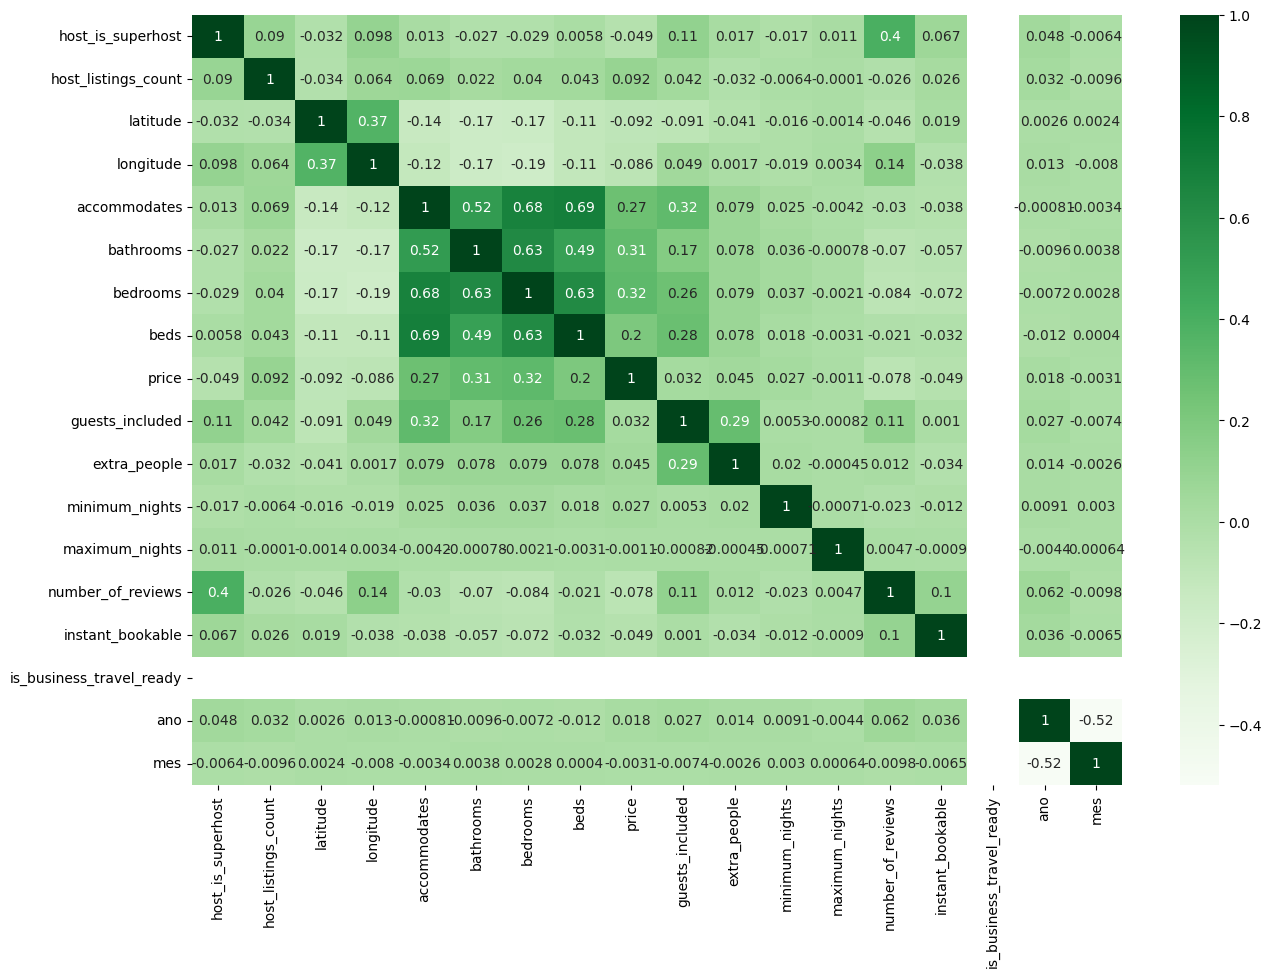

In [14]:
plt.figure(figsize=( 15, 10 ) )
sns.heatmap( correlation_matrix, annot=True, cmap='Greens' )

### Definição de funções para Análise de Outliers

- Vai ser definido algumas funções para ajudar na análise de outliers das colunas e facilitar o processo de exclusão.

### A Exclusão dos outliers seguirá a seguinte lógica:

- Será usado como regra valores abaixo do Q1 - 1.5x Amplitude e valores acima de Q3 + 1.5x Amplitude ( Amplitude = Q3 - Q1 ) 
- A limpeza será iniciada pelas colunas de price ( resultado final que queremos ) e de extra_people( também valor monetário ). Esses são os valroes numericos continuos.
- Depois o foco será em analisar as colunas de valores numéricos discretos ( accomodates, bedrooms, guests_included, etc. )
- E por ultimo será avaliado as colunas de texto e definir quais categorias fazem sentido ser mantidas ou não.

In [15]:
def limites(coluna):
    q1 = coluna.quantile( 0.25 )
    q3 = coluna.quantile( 0.75 )
    amplitude = q3- q1
    return q1- 1.5 * amplitude, q3 + 1.5 * amplitude 

def excluir_outliers( df, nome_coluna ):
    qtde_linhas = df.shape[0]
    lim_inf, lim_sup = limites( df[nome_coluna] )
    df = df.loc[( df[nome_coluna] >= lim_inf ) & ( df[nome_coluna] <= lim_sup ), :]
    linhas_removidas = qtde_linhas - df.shape[0]
    return df, linhas_removidas 



In [16]:
def diagrama_caixa(coluna):
    fig, ( ax1, ax2 ) = plt.subplots( 1, 2 )
    fig.set_size_inches( 15, 5 ) # Aumentando o tamanho do grafico para o tamanho adequado 
    sns.boxplot( x=coluna, ax=ax1 )
    ax2.set_xlim( limites ( coluna ) )
    sns.boxplot( x=coluna, ax=ax2 )

def histograma(coluna):
    plt.figure( figsize=( 15, 5 ) )
    sns.distplot( coluna, hist=True )

def grafico_barra(coluna):
    plt.figure(figsize=( 15, 5 ) )
    ax = sns.barplot(x=coluna.value_counts().index, y=coluna.value_counts())
    ax.set_xlim( limites ( coluna ) )


### Price

c:\Users\dudup\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\dudup\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\dudup\AppData\Local\Temp\ipykernel_2820\2375750146.py:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed29744

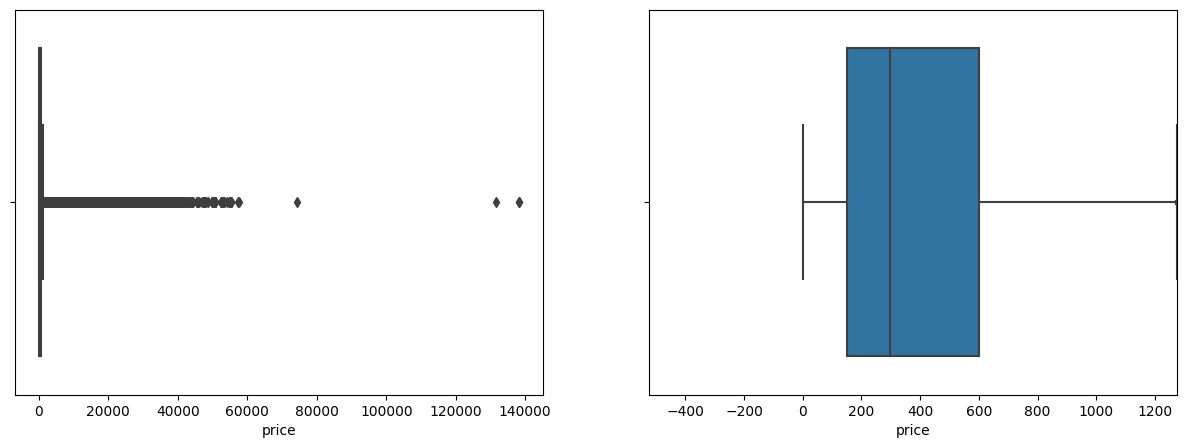

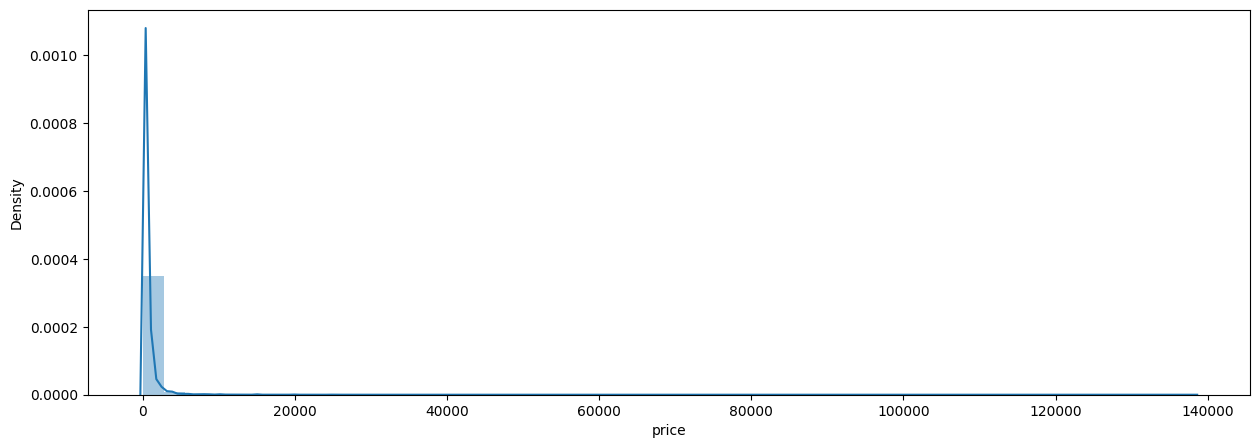

In [17]:
diagrama_caixa(base_airbnb['price'])
histograma(base_airbnb['price'])

- Como está sendo construido um modelo para imoveis comuns, foi assumido que valores acima do limite superior serão apenas de apartamentos de altissimo luxo
    que não é o objetivo principal do projeto. Por isso, podemos excluir esses outliers. 

In [18]:
base_airbnb, linhas_removidas = excluir_outliers( base_airbnb,'price' )

print('{} linhas removidas'.format( linhas_removidas ) ) 

87282 linhas removidas


C:\Users\dudup\AppData\Local\Temp\ipykernel_2820\2375750146.py:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot( coluna, hist=True )
c:\Users\dudup\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\dudup\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operati

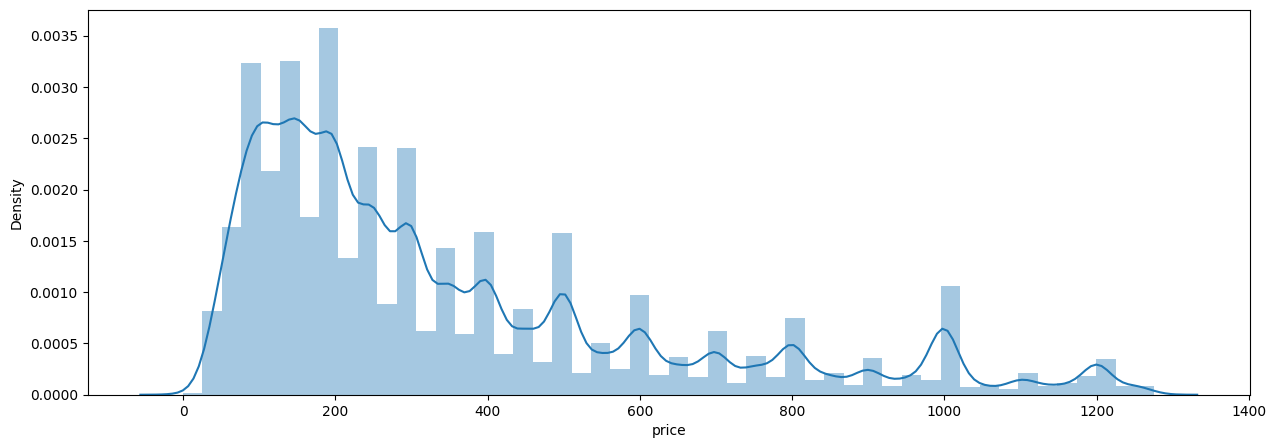

In [19]:
histograma( base_airbnb['price'] )

### extra_people

c:\Users\dudup\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\dudup\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\dudup\AppData\Local\Temp\ipykernel_2820\2375750146.py:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed29744

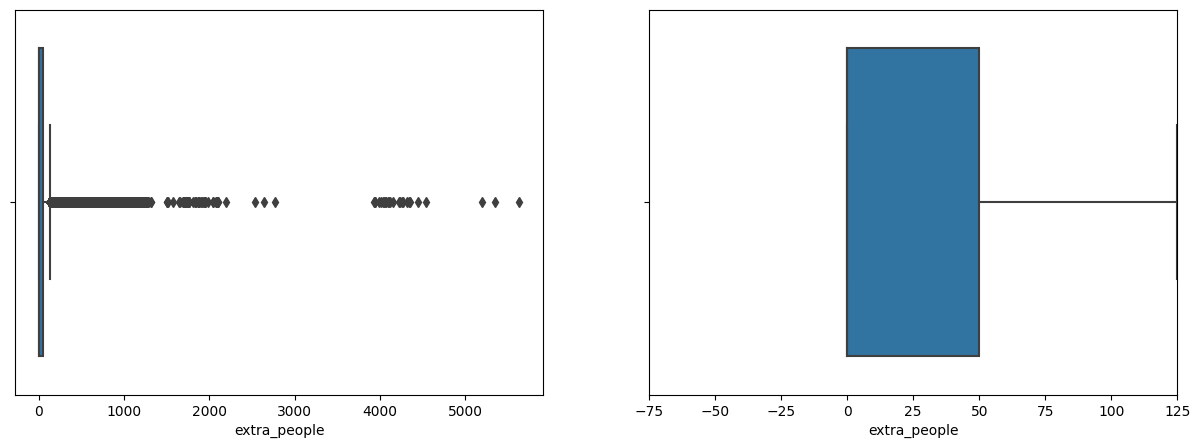

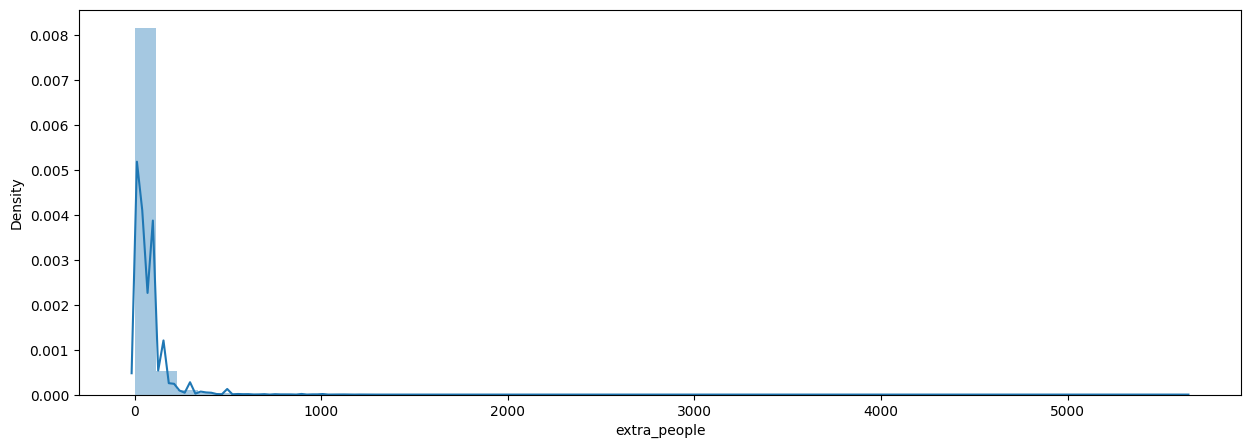

In [20]:
diagrama_caixa(base_airbnb['extra_people']);
histograma(base_airbnb['extra_people']);

In [21]:
base_airbnb, linhas_removidas = excluir_outliers( base_airbnb,'extra_people' )

print('{} linhas removidas'.format( linhas_removidas ) ) 

59194 linhas removidas


C:\Users\dudup\AppData\Local\Temp\ipykernel_2820\2375750146.py:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot( coluna, hist=True )
c:\Users\dudup\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\dudup\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operati

(751233, 23)


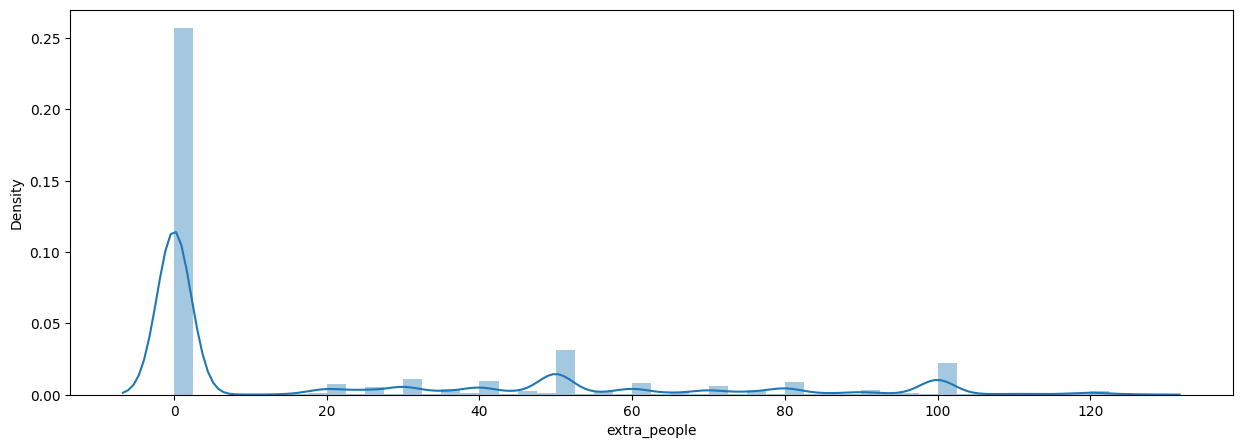

In [22]:
histograma( base_airbnb['extra_people'] )
print(base_airbnb.shape)

### host_listings_count 

c:\Users\dudup\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\dudup\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\dudup\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\dudup\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecat

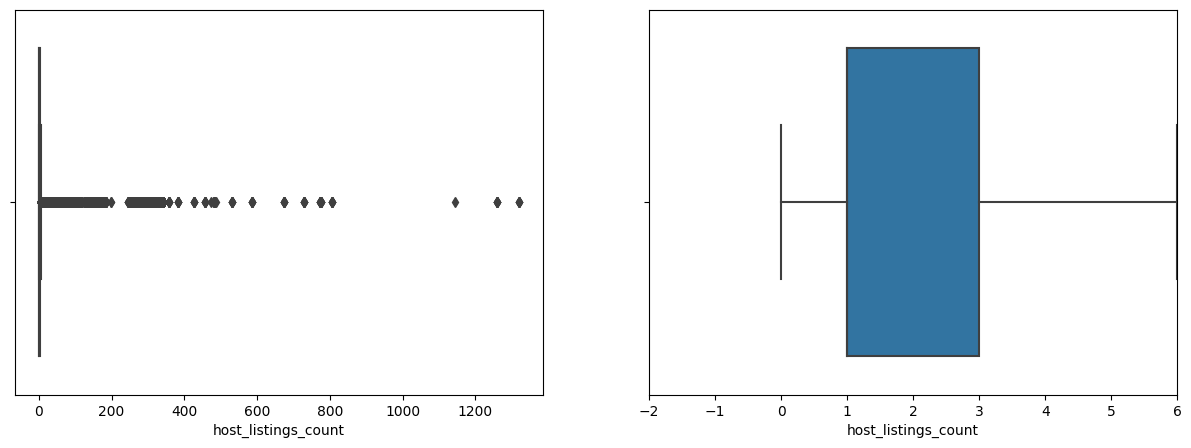

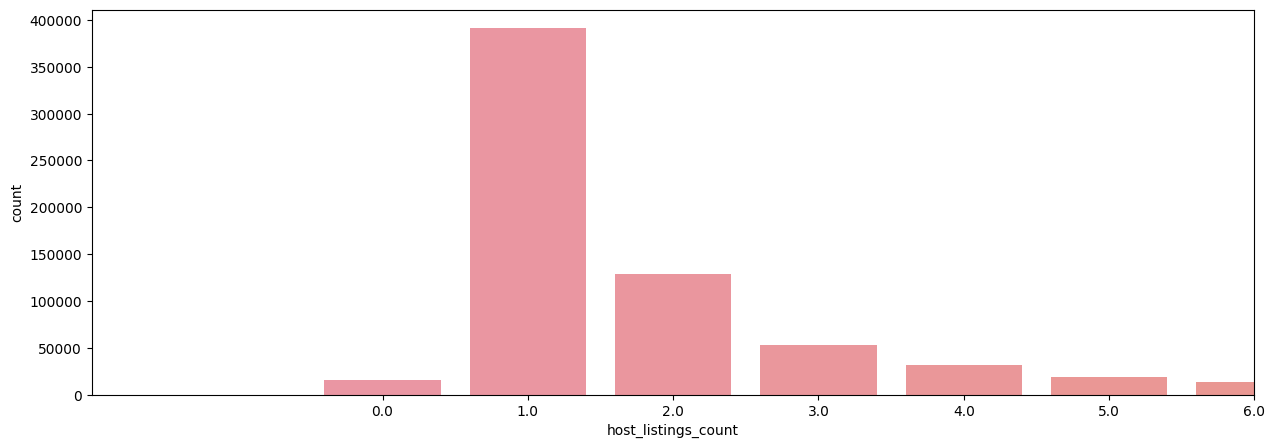

In [23]:
diagrama_caixa(base_airbnb['host_listings_count'])
grafico_barra(base_airbnb['host_listings_count'])

- Os outliers da coluna 'host_listings_counts' (Quantidade de imoveis que os hosts possuem cadastradas) serão excluidos em razão de que hosts com mais de 6 imoveis no Aiirbnb não fazem parte do publico alvo do objetivo do projeto.  

In [24]:
base_airbnb, linhas_removidas = excluir_outliers( base_airbnb,'host_listings_count' )

print('{} linhas removidas'.format( linhas_removidas ) ) 

97723 linhas removidas


### accomodates

c:\Users\dudup\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\dudup\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\dudup\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\dudup\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecat

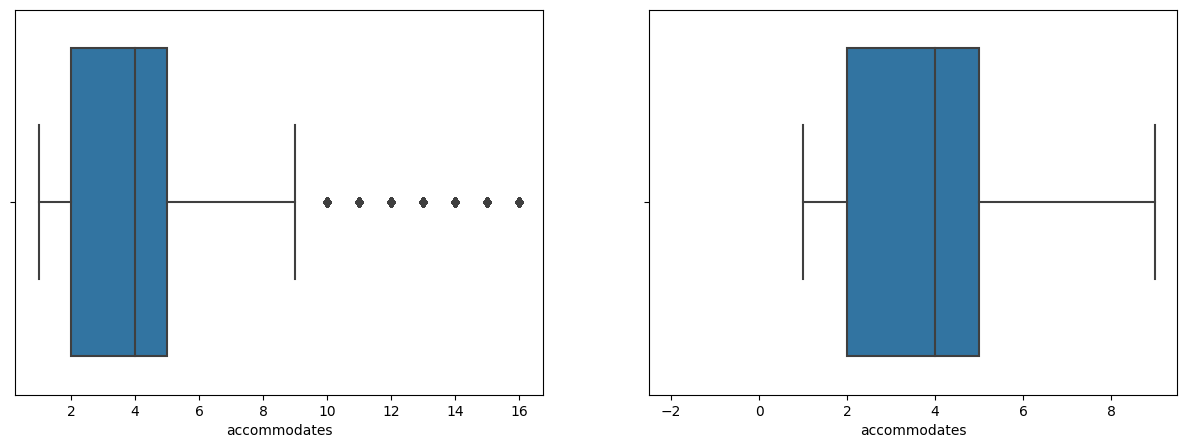

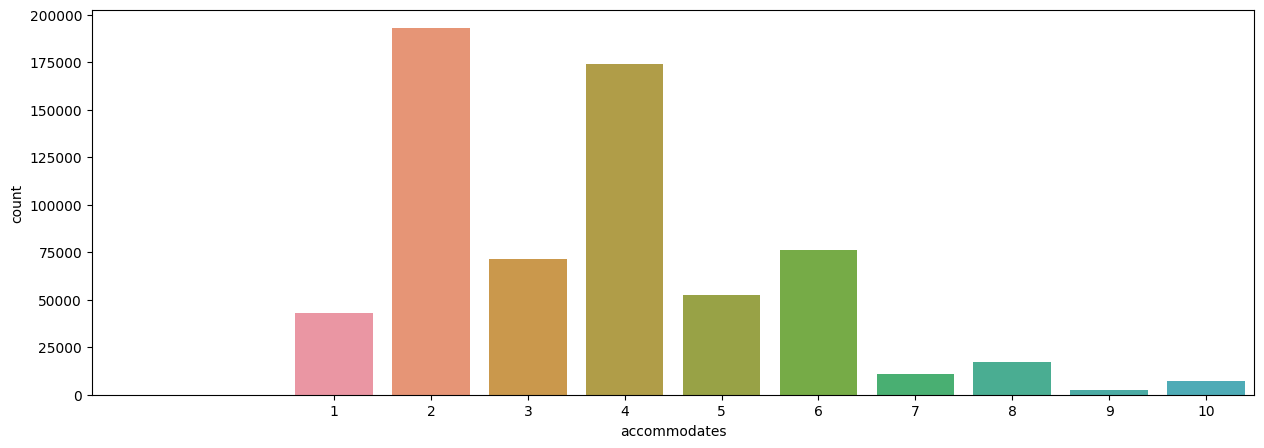

In [25]:
diagrama_caixa(base_airbnb['accommodates'])
grafico_barra(base_airbnb['accommodates'])

- Seguindo a mesma lógica do "host_listings_count" os outliers de accomodates serão excluidos, pois apartamentos que acomodam mais de 9 pessoas já deixa de ser um imovel comum e sai do foco do objetivo do projeto.

In [26]:
base_airbnb, linhas_removidas = excluir_outliers( base_airbnb,'accommodates' )

print('{} linhas removidas'.format( linhas_removidas ) ) 

13146 linhas removidas


### bathrooms

c:\Users\dudup\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\dudup\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\dudup\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\dudup\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecat

<Axes: xlabel='bathrooms', ylabel='count'>

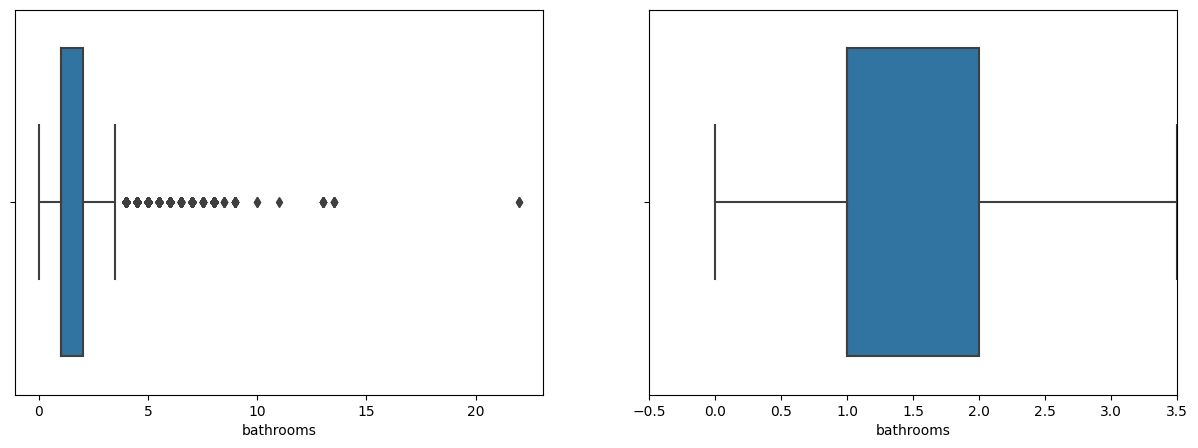

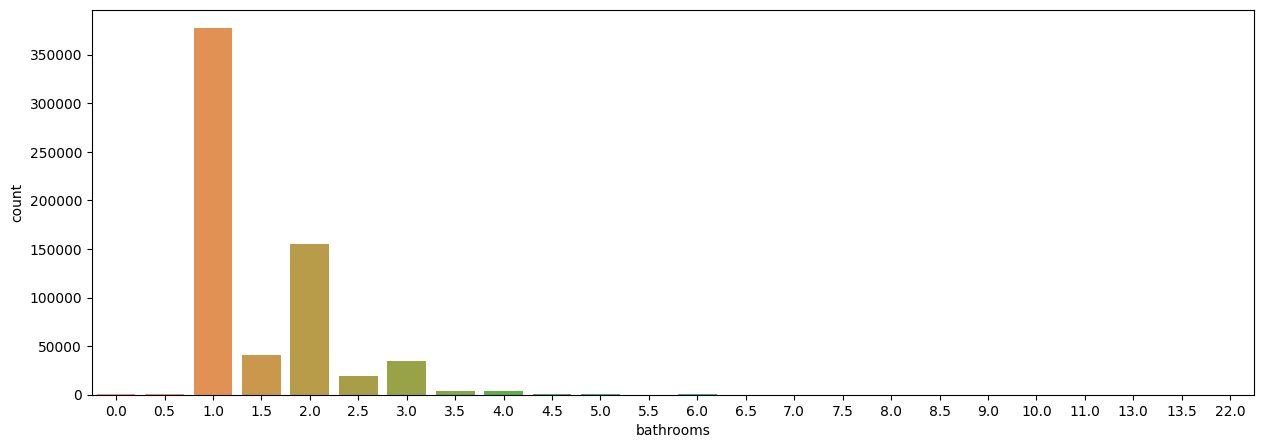

In [27]:
diagrama_caixa(base_airbnb['bathrooms'])
#grafico_barra(base_airbnb['bathrooms'])
plt.figure(figsize=( 15, 5 ) )
sns.barplot(x=base_airbnb['bathrooms'].value_counts().index, y=base_airbnb['bathrooms'].value_counts() )

- Seguindo a mesma lógica dos anteriores, será feito a exclusão dos outlier dessa feature.

In [28]:
base_airbnb, linhas_removidas = excluir_outliers( base_airbnb,'bathrooms' )

print('{} linhas removidas'.format( linhas_removidas ) ) 

6894 linhas removidas


### bedrooms

c:\Users\dudup\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\dudup\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\dudup\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\dudup\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecat

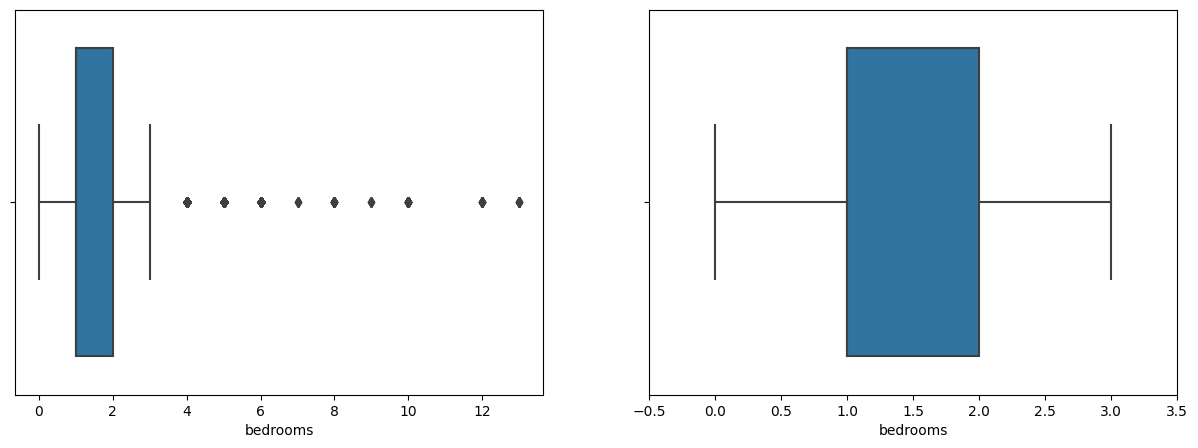

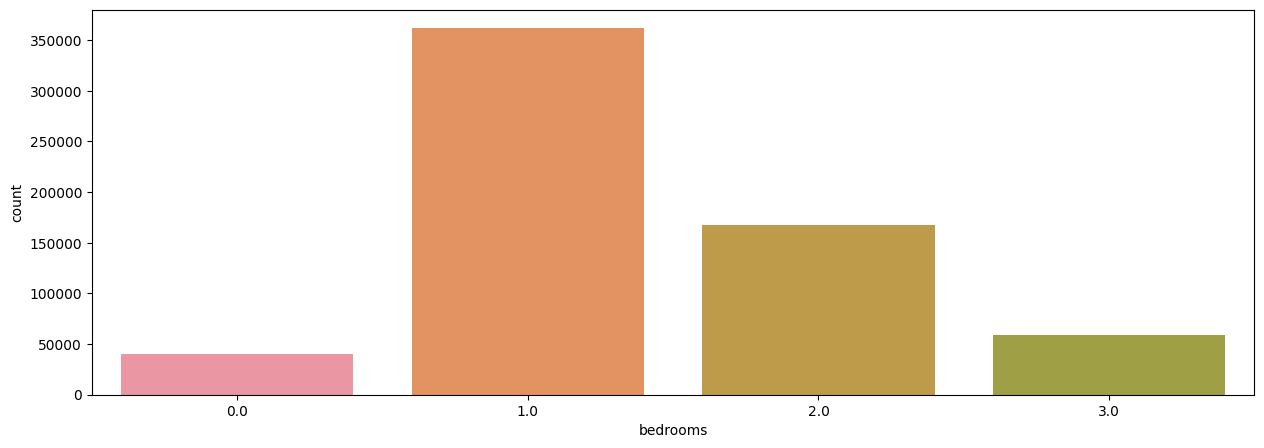

In [29]:
diagrama_caixa(base_airbnb['bedrooms'])
grafico_barra(base_airbnb['bedrooms'])

- Seguindo a mesma lógica utilizada na exclusão dos outlier anteriores, aqui também será excluido os outliers dos quartos.

In [30]:
base_airbnb, linhas_removidas = excluir_outliers( base_airbnb,'bedrooms' )

print('{} linhas removidas'.format( linhas_removidas ) ) 

5482 linhas removidas


### beds 

c:\Users\dudup\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\dudup\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\dudup\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\dudup\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecat

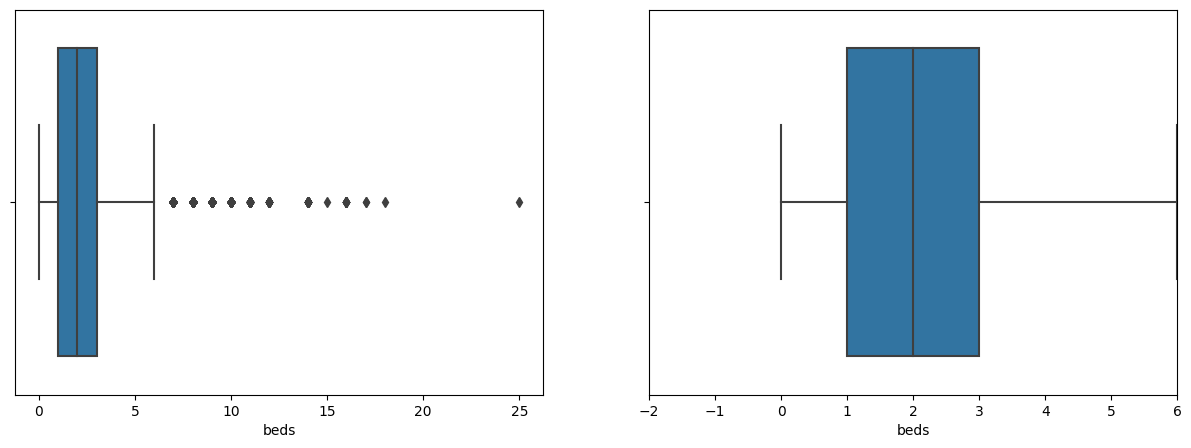

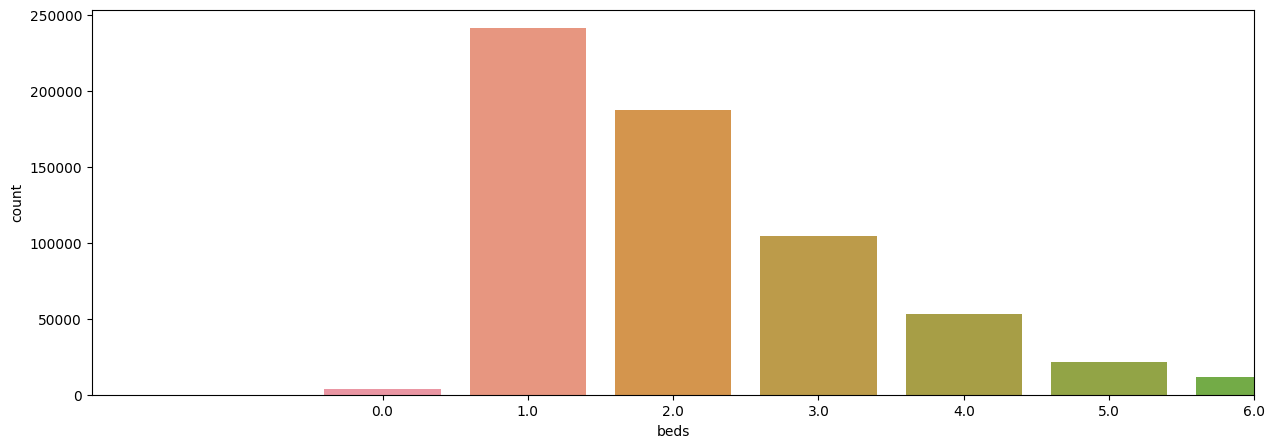

In [31]:
diagrama_caixa(base_airbnb['beds'])
grafico_barra(base_airbnb['beds'])

- Seguindo a mesma lógica utilizada na exclusão dos outlier anteriores, aqui também será excluido os ouliers das camas.

In [32]:
base_airbnb, linhas_removidas = excluir_outliers( base_airbnb,'beds' )

print('{} linhas removidas'.format( linhas_removidas ) ) 

5622 linhas removidas


### guests_included 

(1.0, 1.0)


c:\Users\dudup\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\dudup\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\dudup\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='guests_included', ylabel='count'>

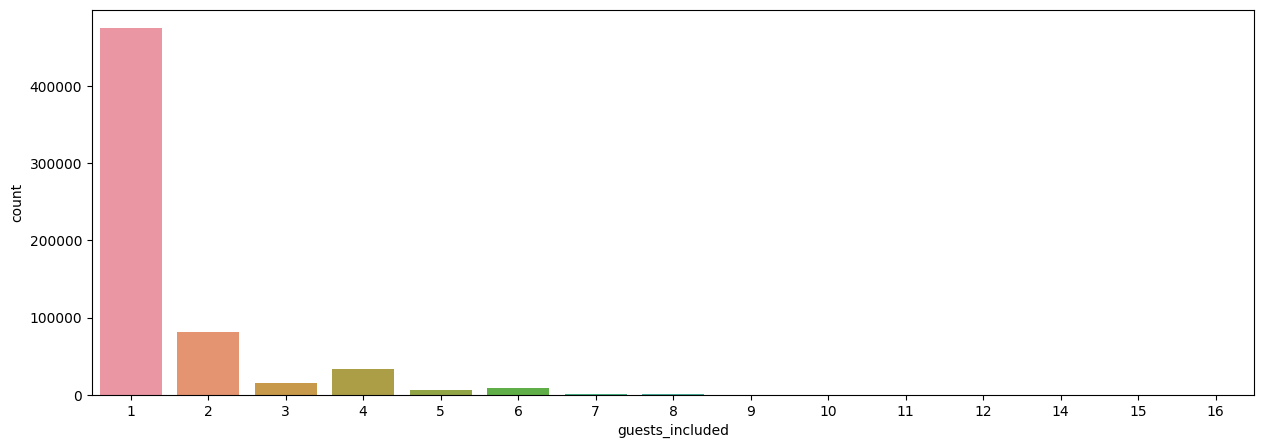

In [33]:
#diagrama_caixa(base_airbnb['guests_included'])
#grafico_barra(base_airbnb['guests_included'])

print(limites(base_airbnb['guests_included'] ) )
plt.figure(figsize=( 15, 5 ) )
sns.barplot(x=base_airbnb['guests_included'].value_counts().index, y=base_airbnb['guests_included'].value_counts())

- A feature 'guests_included' será removida da análise. Ao que tudo indica, os usuarios do airbnb usam mais o valor padrão do airbnb como 1 guest_included. Isso pode levar o nosso modelo a considerar uma feature que na verdade não é essencial para a definição do preço, por isso, foi concluido que seria melhor excluir a coluna da análise.

In [34]:
base_airbnb = base_airbnb.drop('guests_included', axis=1 )
base_airbnb.shape

(622366, 22)

### minimum_nights

c:\Users\dudup\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\dudup\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\dudup\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\dudup\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecat

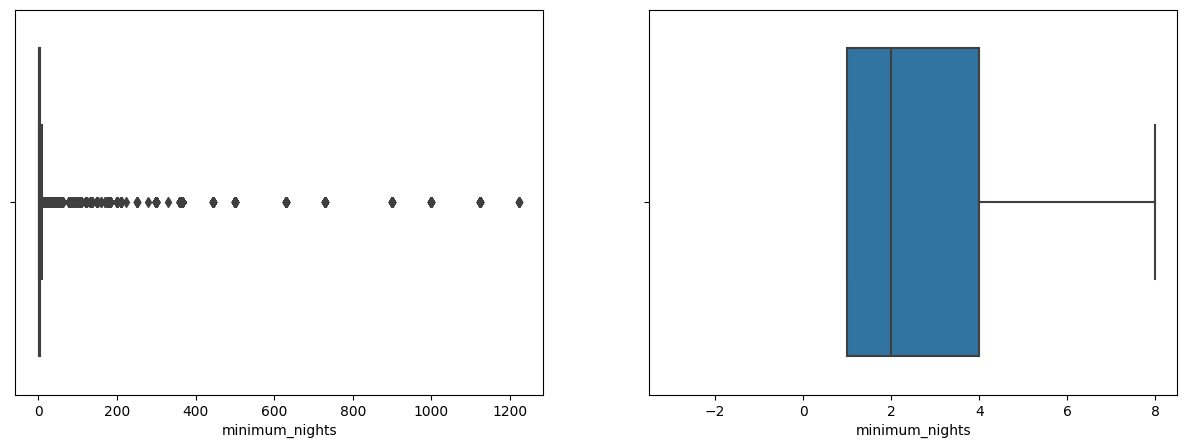

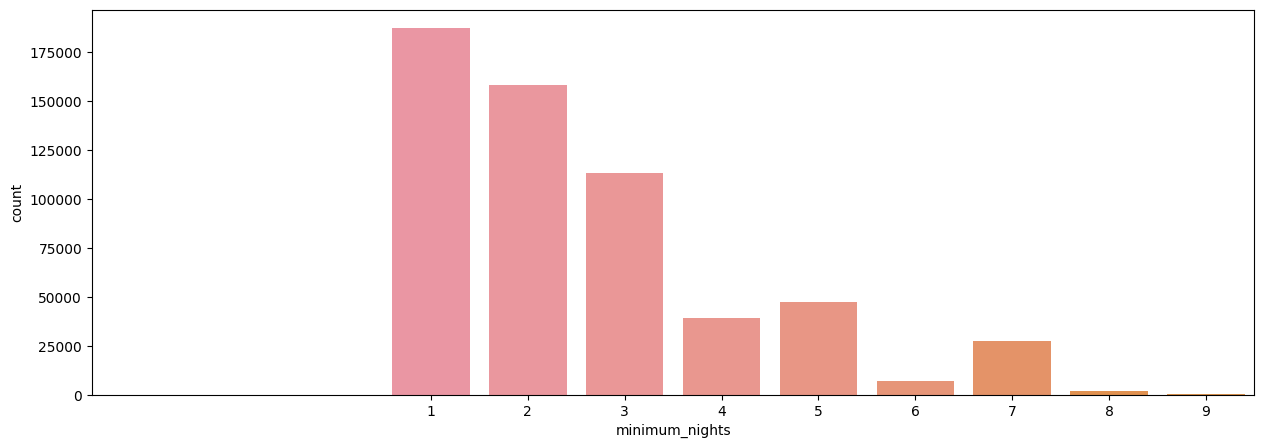

In [35]:
diagrama_caixa(base_airbnb['minimum_nights'])
grafico_barra(base_airbnb['minimum_nights'])

-  Aqui temos uma motivação diferente para a exclusão, o modelo a ser criado tem foco em precificar Casas/Apartamentos que uma pessoa comum disponibilizaria, nesse caso apartamentos com no minimo mais de 8 noites pdoeriam ser apartamentos para aluguel de temporadas ou aqueles em que o host gostaria de alugar mensalmente. 

In [36]:
base_airbnb, linhas_removidas = excluir_outliers( base_airbnb,'minimum_nights' )

print('{} linhas removidas'.format( linhas_removidas ) ) 

40383 linhas removidas


### maximum_nights 

c:\Users\dudup\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\dudup\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\dudup\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\dudup\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecat

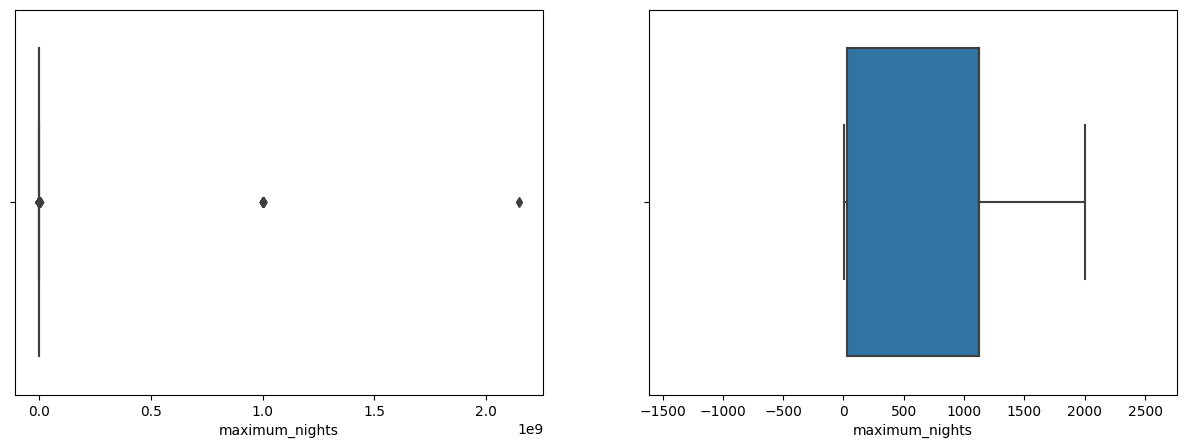

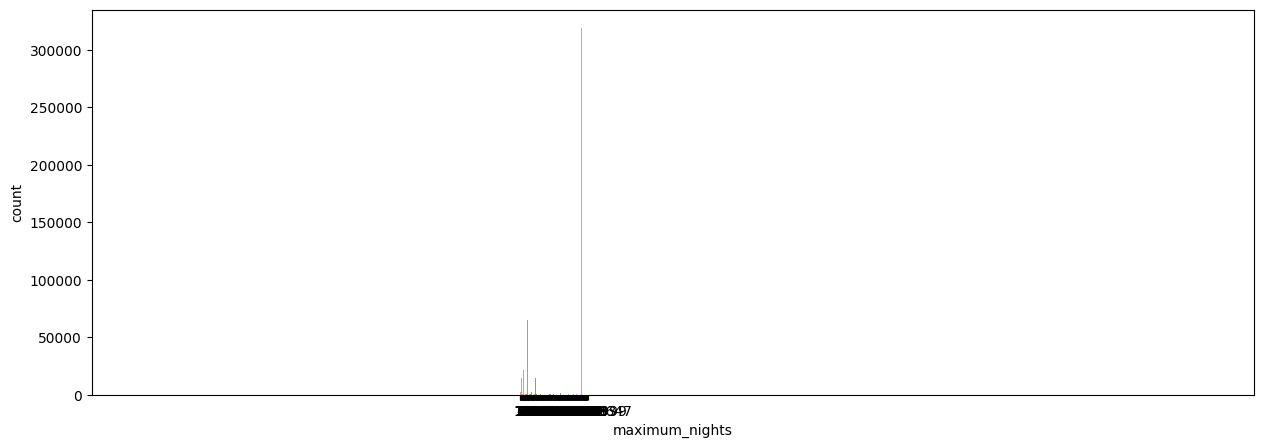

In [37]:
diagrama_caixa(base_airbnb['maximum_nights'])
grafico_barra(base_airbnb['maximum_nights'])

- Aparantemente essa coluna não é preenchida corretamente pelos hosts, então ela será irrelevante para o modelo, em virtude disso a feature será excluida.

In [38]:
base_airbnb = base_airbnb.drop('maximum_nights', axis=1)
base_airbnb.shape


(581983, 21)

### number_of_reviews 


c:\Users\dudup\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\dudup\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\dudup\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\dudup\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecat

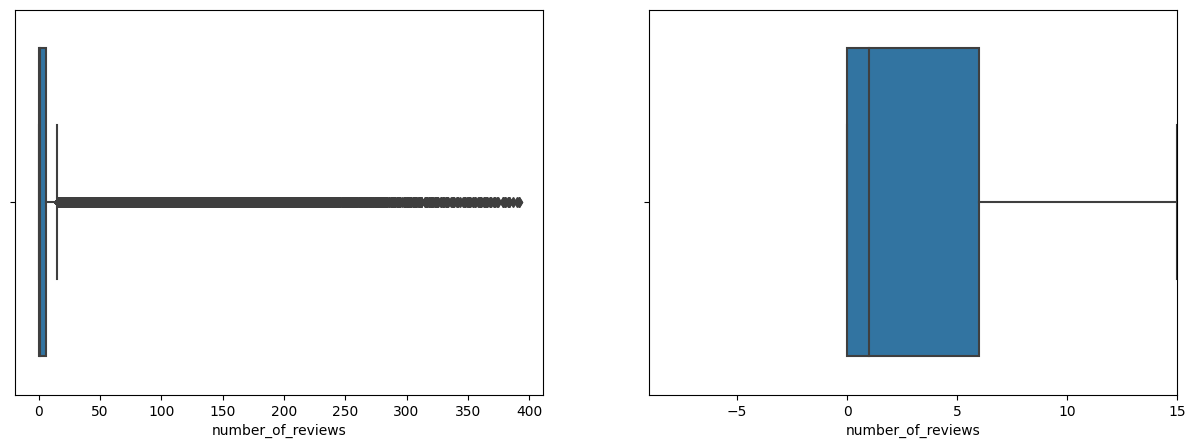

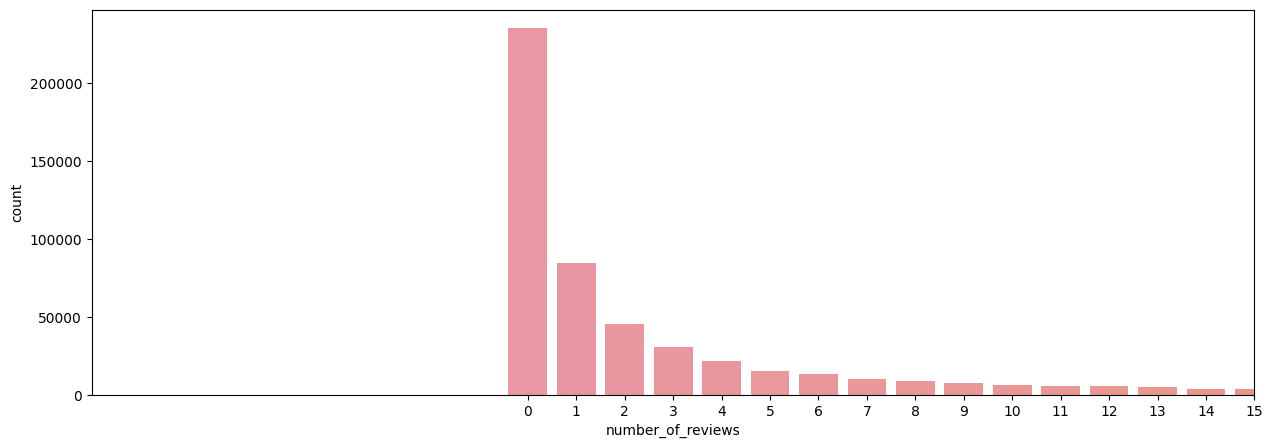

In [39]:
diagrama_caixa(base_airbnb['number_of_reviews'])
grafico_barra(base_airbnb['number_of_reviews'])

- Essa feature após testes, não é relevante para o modelo, por isso será excluida.

In [40]:
base_airbnb = base_airbnb.drop('number_of_reviews', axis=1)
base_airbnb.shape

(581983, 20)

## Tratamento de Colunas de valores Text

### property_type 

property_type
Apartment                 458354
House                      51387
Condominium                26456
Serviced apartment         12671
Loft                       12352
Guest suite                 3621
Bed and breakfast           3472
Hostel                      2665
Guesthouse                  2155
Other                       1957
Villa                       1294
Townhouse                    969
Aparthotel                   693
Chalet                       481
Earth house                  468
Tiny house                   457
Boutique hotel               447
Hotel                        376
Casa particular (Cuba)       298
Cottage                      230
Bungalow                     207
Dorm                         185
Cabin                        141
Nature lodge                 124
Castle                        80
Treehouse                     76
Island                        54
Boat                          53
Hut                           40
Campsite                     

c:\Users\dudup\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\dudup\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\dudup\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


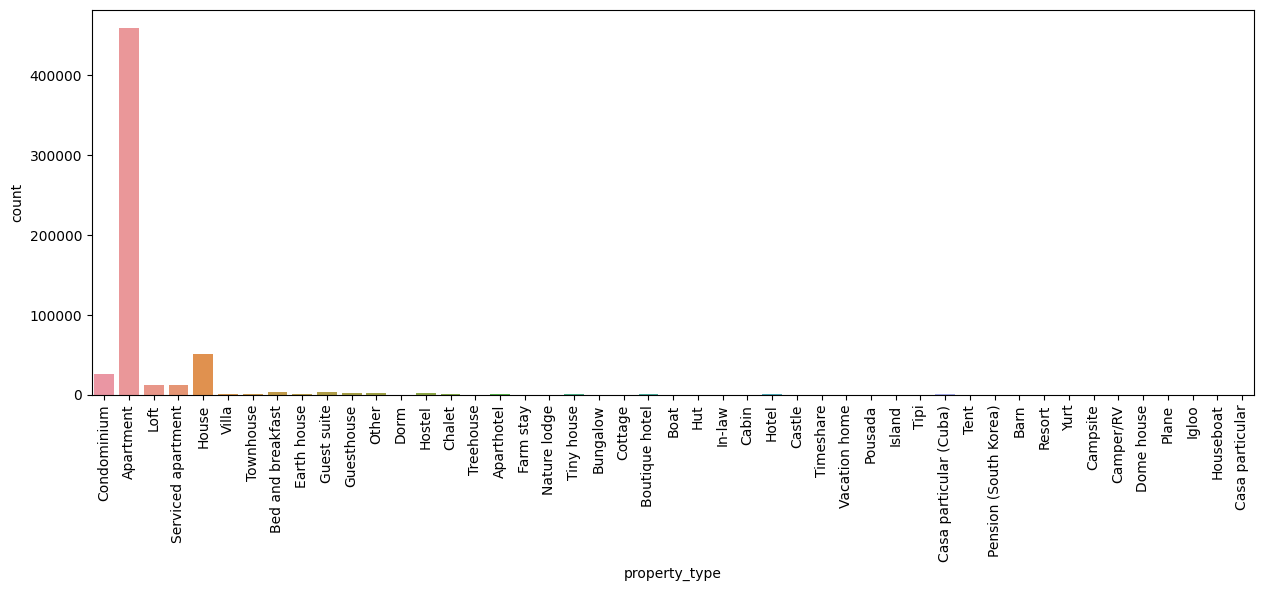

In [41]:
print(base_airbnb['property_type'].value_counts())

# Visualziar o print acima na forma de gráfico
plt.figure(figsize=( 15, 5 ) )
grafico = sns.countplot( data=base_airbnb, x='property_type' )
grafico.tick_params( axis='x', rotation=90 )

- O objetivo desse passo não é 'excluir' os outliers e sim agrupar valores que são muito pequenos.

- Para facilitar o modelo, toda modalidade de 'propriedade' que tiver menos de 2.000 propriedades cadastradas na base de dados, será agrupado em um grupo chamado 'outros'. 

['Serviced apartment', 'Loft', 'Guest suite', 'Bed and breakfast', 'Hostel', 'Guesthouse', 'Other', 'Villa', 'Townhouse', 'Aparthotel', 'Chalet', 'Earth house', 'Tiny house', 'Boutique hotel', 'Hotel', 'Casa particular (Cuba)', 'Cottage', 'Bungalow', 'Dorm', 'Cabin', 'Nature lodge', 'Castle', 'Treehouse', 'Island', 'Boat', 'Hut', 'Campsite', 'Resort', 'Camper/RV', 'Yurt', 'Tent', 'Tipi', 'Barn', 'Farm stay', 'Pension (South Korea)', 'Dome house', 'Igloo', 'In-law', 'Vacation home', 'Timeshare', 'Pousada', 'Houseboat', 'Casa particular', 'Plane']
property_type
Apartment      458354
House           51387
Outros          45786
Condominium     26456
Name: count, dtype: int64


c:\Users\dudup\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\dudup\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\dudup\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


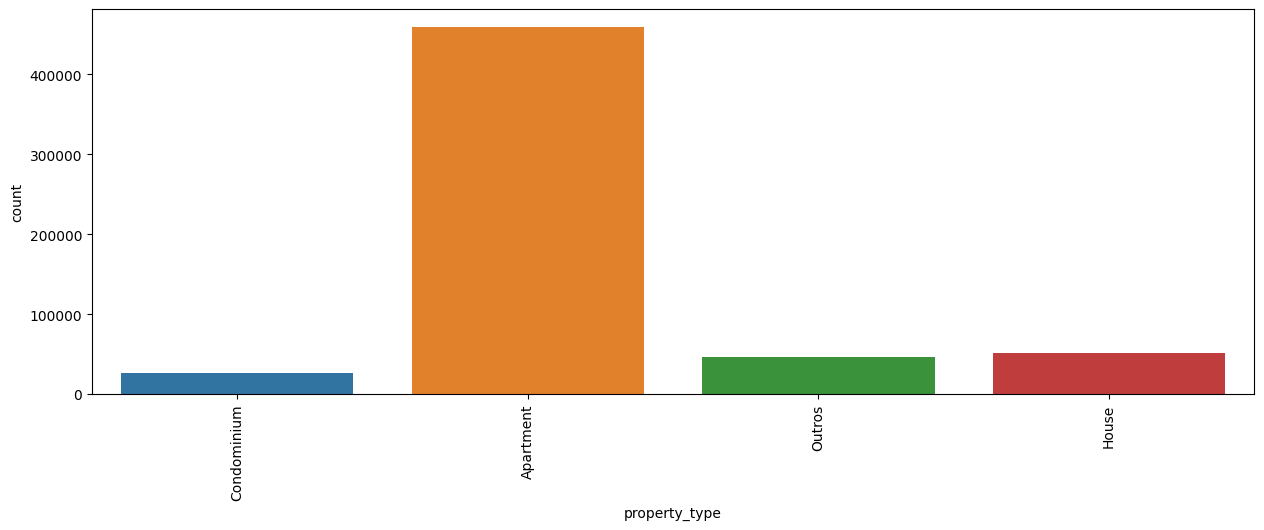

In [42]:
tabela_tipos_casa = base_airbnb['property_type'].value_counts()
colunas_agrupar = []


for tipo in tabela_tipos_casa.index:
    if tabela_tipos_casa[tipo] < 20000:
        colunas_agrupar.append( tipo )
print( colunas_agrupar )

for tipo in colunas_agrupar:
    base_airbnb.loc[base_airbnb['property_type'] == tipo, 'property_type'] = 'Outros'

print(base_airbnb['property_type'].value_counts())

plt.figure(figsize=( 15, 5 ) )
grafico = sns.countplot( data=base_airbnb, x='property_type' )
grafico.tick_params( axis='x', rotation=90 )


### room_type 

room_type
Entire home/apt    372443
Private room       196859
Shared room         11714
Hotel room            967
Name: count, dtype: int64


c:\Users\dudup\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\dudup\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\dudup\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


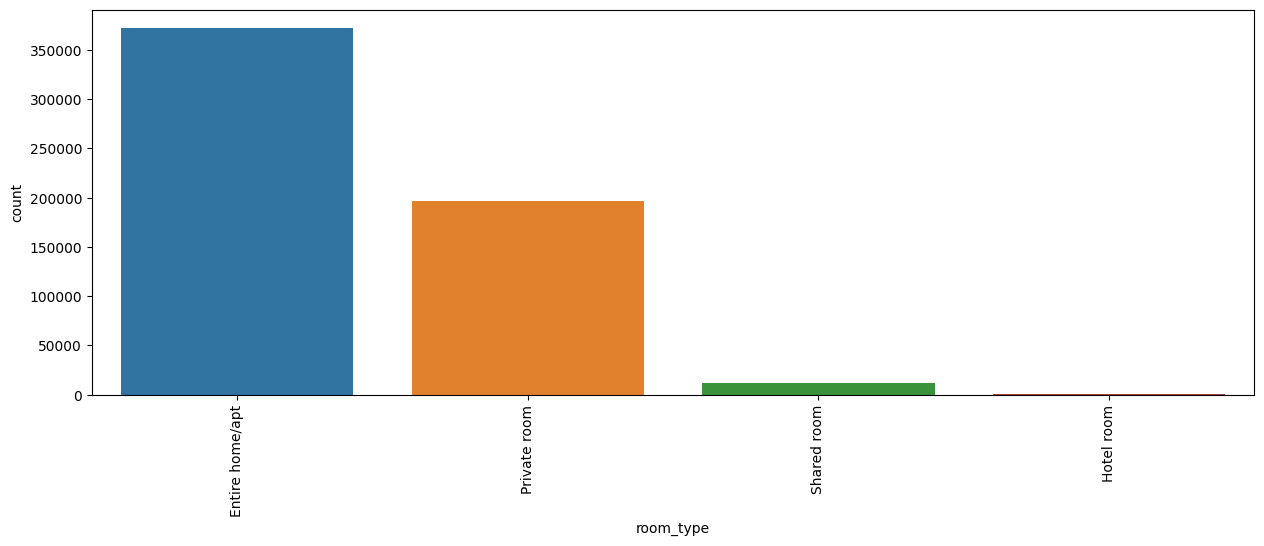

In [43]:
print(base_airbnb['room_type'].value_counts())
plt.figure(figsize=( 15, 5 ) )
grafico = sns.countplot( data=base_airbnb, x='room_type' )
grafico.tick_params( axis='x', rotation=90 )

- Essa feature não será necessário fazer nada, aparentemente está bem distribuida.

### bed_type

- Aqui também os valores não estão sendo excluidos e sim agrupados em uma unica categória.

['Pull-out Sofa', 'Futon', 'Airbed', 'Couch']
bed_type
Real Bed    570643
Outros       11340
Name: count, dtype: int64


c:\Users\dudup\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\dudup\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\dudup\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


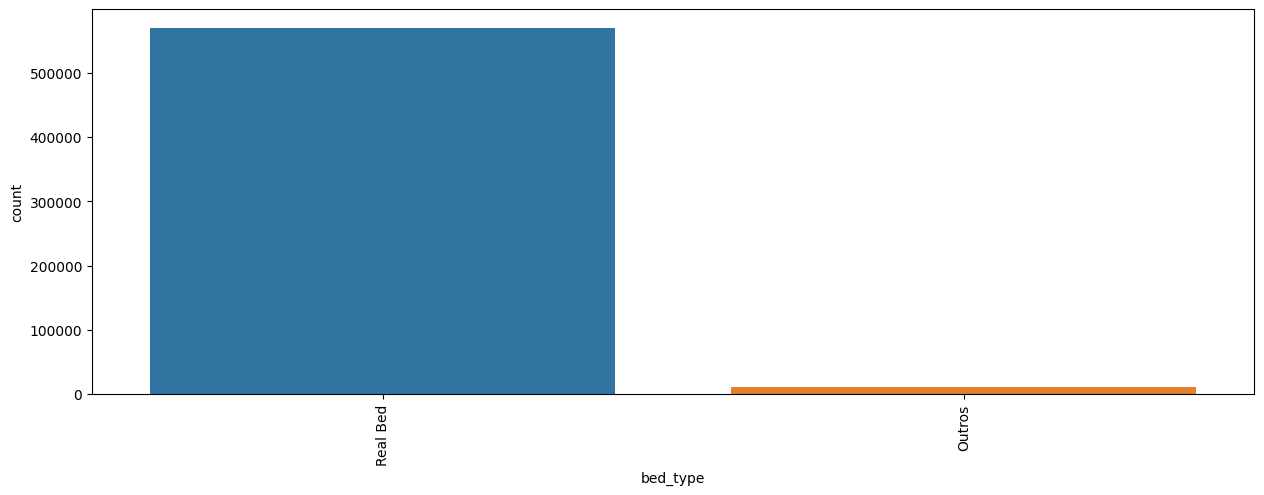

In [44]:
# Agrupando categorias de bed_type
tabela_bed = base_airbnb['bed_type'].value_counts()

colunas_agrupar = []


for tipo in tabela_bed.index:
    if tabela_bed[tipo] < 10000:
        colunas_agrupar.append( tipo )
print( colunas_agrupar );

for tipo in colunas_agrupar:
    base_airbnb.loc[base_airbnb['bed_type'] == tipo, 'bed_type'] = 'Outros'

print(base_airbnb['bed_type'].value_counts());
plt.figure(figsize=( 15, 5 ) );
grafico = sns.countplot(x='bed_type', data=base_airbnb )
grafico.tick_params( axis='x', rotation=90 )

- Posteriormente foi identificado que essa feature não tem nenhum peso consideravel no desempenho do algoritmo, por isso sera removida. 

In [45]:
base_airbnb = base_airbnb.drop('bed_type', axis=1)
base_airbnb.shape

(581983, 19)

### cancellation_policy

In [46]:
print(base_airbnb['cancellation_policy'].value_counts())

# Agrupando categorias de cancellation_pollicy
tabela_cancellation = base_airbnb['cancellation_policy'].value_counts()
colunas_agrupar = []


for tipo in tabela_cancellation.index:
    if tabela_cancellation[tipo] < 10000:
        colunas_agrupar.append( tipo )
print( colunas_agrupar )

for tipo in colunas_agrupar:
    base_airbnb.loc[base_airbnb['cancellation_policy'] == tipo, 'cancellation_policy'] = 'strict'

print(base_airbnb['cancellation_policy'].value_counts())

cancellation_policy
flexible                       258096
strict_14_with_grace_period    200743
moderate                       113281
strict                           9696
super_strict_60                   135
super_strict_30                    32
Name: count, dtype: int64
['strict', 'super_strict_60', 'super_strict_30']
cancellation_policy
flexible                       258096
strict_14_with_grace_period    200743
moderate                       113281
strict                           9863
Name: count, dtype: int64


- Aqui também foi identificado que essa feature não tem nenhum peso consideravel no desempenho do algoritmo, por isso sera removida. 

In [47]:
base_airbnb = base_airbnb.drop('cancellation_policy', axis=1)
base_airbnb.shape

(581983, 18)

### amenities 

- Como tem uma diversidade grande no amenities e as muitas vezes as mesmas amenities pode ser escritas de formas diferentes, será avaliado a quantidade  de amenities como parametro para o modelo

In [48]:
# Tratando os valores da coluna amenities, muito dos valores possuiam aspas e outros não, como forma de separar cada valor, foi feito um split usando a virgula
print(base_airbnb['amenities'].iloc[0].split(','))


#separando, fazendo a contagem do numero de amenities da coluna para cada item e criando uma nova coluna com a contagem
base_airbnb['n_amenities'] = base_airbnb['amenities'].str.split(',').apply( len )

#Tirando a coluna amenities do dataset
base_airbnb = base_airbnb.drop('amenities', axis=1 )
base_airbnb.shape


['{TV', '"Cable TV"', 'Internet', 'Wifi', '"Air conditioning"', 'Kitchen', '"Paid parking off premises"', '"Smoking allowed"', 'Doorman', 'Elevator', '"Hot tub"', '"Family/kid friendly"', '"Suitable for events"', 'Essentials', '"24-hour check-in"', 'Hangers', '"Hair dryer"', 'Iron', '"Laptop friendly workspace"', '"Self check-in"', '"Front desk/doorperson"', '"Private entrance"', '"Hot water"', '"Bed linens"', '"Luggage dropoff allowed"}']


(581983, 18)

c:\Users\dudup\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\dudup\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\dudup\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\dudup\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecat

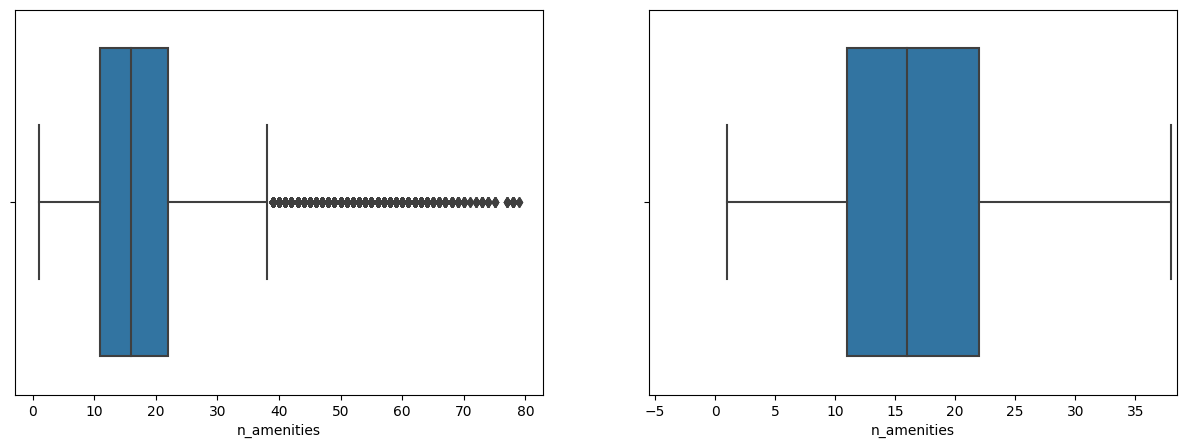

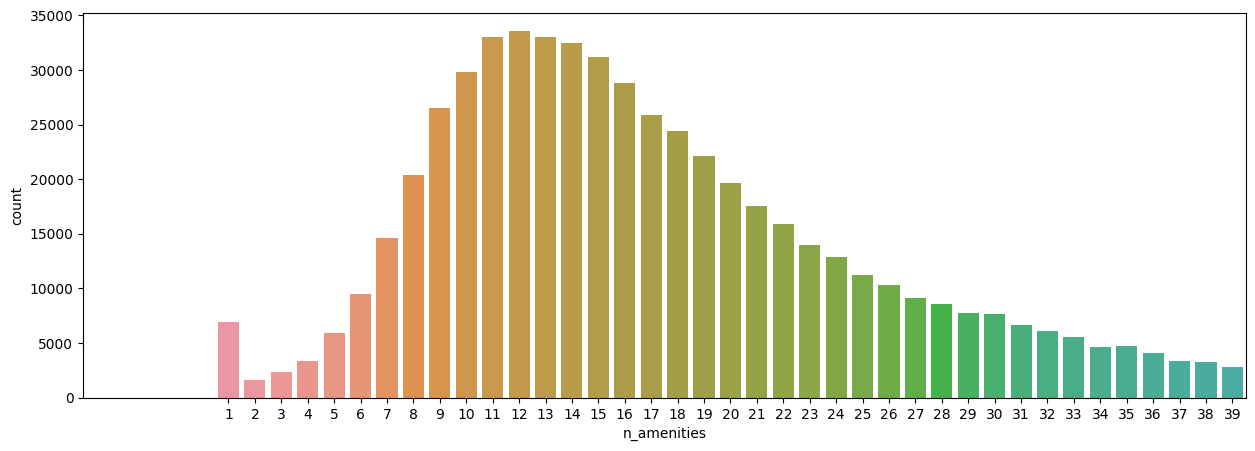

In [49]:
# plotando o grafico com as informações da nova coluna, para verificação de outliers
diagrama_caixa(base_airbnb['n_amenities'])
grafico_barra(base_airbnb['n_amenities'])

- Essa virou uma coluna de valor numérico e como todas as outras colunas de valores numéricos, foram excluidos os outliers utilizando a mesma logica dos anteriores.

In [50]:
# Excluindo os outliers da nova coluna 
base_airbnb, linhas_removidas = excluir_outliers( base_airbnb,'n_amenities' )

print('{} linhas removidas'.format( linhas_removidas ) ) 

24343 linhas removidas


                       
### Visualização de Mapa das propriedades



In [51]:
amostra = base_airbnb.sample( n=50000 )
centro_mapa= {'lat':amostra.latitude.mean(), 'lon':amostra.longitude.mean() }
mapa = px.density_mapbox( amostra, lat='latitude', lon='longitude', z='price', radius=2.5,
                             center=centro_mapa, zoom=10,
                             mapbox_style='open-street-map' )
mapa.show()


### Encoding

- Será preciso ajustar as features para facilitar o trabalho do modelo futuro ( Features de categoria, true e false, etc )
- Features de valores True ou False, a substituição ocorrera de forma que True seja 1 e False seja 0.
- Features de Categoria ( Features em que os valores da coluna são textos ), será utilizado o método de enconding de variaveis dummies ( variaveis binárias )

In [52]:
print(base_airbnb.iloc[1])

host_is_superhost                         0
host_listings_count                     3.0
latitude                         -22.977118
longitude                        -43.190453
property_type                     Apartment
room_type                   Entire home/apt
accommodates                              3
bathrooms                               1.0
bedrooms                                1.0
beds                                    2.0
price                                 161.0
extra_people                           45.0
minimum_nights                            4
instant_bookable                          0
is_business_travel_ready                  0
ano                                    2018
mes                                       4
n_amenities                              14
Name: 3, dtype: object


In [53]:
base_airbnb = base_airbnb.drop('is_business_travel_ready', axis=1)
base_airbnb.shape

colunas_tf = [ 'host_is_superhost','instant_bookable']
base_airbnb_encoded = base_airbnb.copy()

for coluna in colunas_tf:
     base_airbnb_encoded.loc[base_airbnb_encoded[coluna] == 't', coluna ] = 1 
     base_airbnb_encoded.loc[base_airbnb_encoded[coluna] == 'f', coluna ] = 0

In [60]:
colunas_categorias = [ 'property_type', 'room_type' ]
base_airbnb_encoded = pd.get_dummies(data=base_airbnb_encoded, columns=colunas_categorias, dtype=int )
display(base_airbnb_encoded.head())

host_is_superhost  host_listings_count   latitude  longitude  accommodates  \
1                  1                  2.0 -22.965919 -43.178963             5   
3                  0                  3.0 -22.977118 -43.190453             3   
4                  1                  1.0 -22.983025 -43.214272             3   
5                  1                  1.0 -22.988165 -43.193588             3   
6                  1                  1.0 -22.981270 -43.190456             2   

   bathrooms  bedrooms  beds  price  extra_people  ...  mes  n_amenities  \
1        1.0       2.0   2.0  270.0          51.0  ...    4           25   
3        1.0       1.0   2.0  161.0          45.0  ...    4           14   
4        1.0       1.0   2.0  222.0          68.0  ...    4           16   
5        1.5       1.0   2.0  308.0          86.0  ...    4           30   
6        1.0       1.0   2.0  219.0          80.0  ...    4           30   

   property_type_Apartment  property_type_Condominium  property_type_House  \
1                        0                          1                    0   
3                        1                          0                    0   
4                        1                          0                    0   
5                        1                          0                    0   
6                        0                          0                    0   

   property_type_Outros  room_type_Entire home/apt  room_type_Hotel room  \
1                     0                          1                     0   
3                     0                          1                     0   
4                     0                          1                     0   
5                     0                          1                     0   
6                     1                          1                     0   

   room_type_Private room  room_type_Shared room  
1                       0                      0  
3                       0                      0  
4                       0                      0  
5                       0                      0  
6                       0                      0  

[5 rows x 23 columns]

### Modelo de Previsão

- Métricas De Avaliação
    
    - Aqui será usado o R² como métrica para saber o quão bem o modelo conseguirá explicar o preço. ( quanto mais proximo de 100 chegar melhor )
    - Será feito também o cálculo do Erro Quadrático Médio que vai mostrar o quanto o modelo está errando. ( quanto menor for o valor melhor )

In [83]:
# Função para Descobrir o MPE
def mean_percentage_error( y_test, previsao ):
    return np.mean ( ( y_test - previsao ) / y_test )  

# Função para Descobrir o MAPE
def mean_absolute_percentage_error(y_test, previsao):
    denominador = np.maximum(np.abs(y_test), 1e-10)  # Evita a divisão por zero
    return np.mean(np.abs((y_test - previsao) / denominador)) * 100

def ml_error(model_name, y_test, previsao):
    # Tratamento de valores infinitos e NaN
    y_test = np.nan_to_num(y_test, nan=np.nan, posinf=np.nan, neginf=np.nan)
    previsao = np.nan_to_num(previsao, nan=np.nan, posinf=np.nan, neginf=np.nan)

    # Filtrar NaN para evitar problemas no cálculo de métricas
    indices_validos = ~np.isnan(y_test) & ~np.isnan(previsao)
    y_test = y_test[indices_validos]
    previsao = previsao[indices_validos]

    r2 = mt.r2_score(y_test, previsao)
    mae = mt.mean_absolute_error(y_test, previsao)
    mape = mean_absolute_percentage_error(y_test, previsao)
    rmse = np.sqrt(mt.mean_squared_error(y_test, previsao))

    return pd.DataFrame({
        'Model Name': model_name,
        'MAE': mae,
        'MAPE': mape,
        'RMSE': rmse,
        'R2': r2
    }, index=[0])

In [67]:
def avaliar_modelo(nome_modelo, y_test, previsao ):
    r2 = mt.r2_score( y_test, previsao )
    mae = mt.mean_absolute_error( y_test, previsao ) 
    mape = mean_absolute_percentage_error( y_test, previsao )
    rsme = np.sqrt( mt.mean_squared_error( y_test, previsao ) )
    return f'Modelo {nome_modelo}: \n R²:{r2:.2%}\n MAE:{mae:.2%} \n MAPE:{mape:.2%} \n RSME:{rsme:.2f}'


In [112]:

# Função para execução do Cross Validation dos modelos
def cross_validation( x_training, kfold, model_name, model, verbose=False ):
    mae_list = []
    mape_list = []
    rmse_list = []

    for k in reversed( range( 1, kfold+1 ) ):
        if verbose:
            print( '\n KFold Number: {}'.format( k ) )

        # Training and Validation DataSet

        # Training
        xtraining = base_airbnb_encoded.drop( 'price', axis=1 )
        ytraining = base_airbnb_encoded['price']

        # Validation 
        xvalidation = base_airbnb_encoded.drop( 'price', axis=1 )
        yvalidation = base_airbnb_encoded['price']

        # Model
        m = model.fit( xtraining, ytraining )

        # Prediction
        yhat = m.predict( xvalidation )

        # Performance 
        m_result = ml_error( model_name,  yvalidation , yhat  )
        
        # Store Performance Of Each Fold Iteration
        mae_list.append(  m_result['MAE'] )
        mape_list.append( m_result['MAPE'] )
        rmse_list.append( m_result['RMSE'] )


    return pd.DataFrame( { 'Model Name': model_name,
                           'MAE CV': np.round( np.mean( mae_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mae_list ), 2 ).astype( str ),  
                           'MAPE CV': np.round( np.mean( mape_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mape_list ), 2 ).astype( str ),  
                           'RMSE CV': np.round( np.mean( rmse_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( rmse_list ), 2 ).astype( str ) }, index=[0] )

- Os seguintes modelos foram escolhidos para serem testados
    1. RandomForest
    2. LinearRegression
    3. Extra Tree

Esses são alguns modelos existentes que são capazes de fazer regressão, ou seja, previsão fazendo a utilização de valores numéricos.


In [68]:
import xgboost as xgb

In [141]:
modelo_rf = RandomForestRegressor()
modelo_lr = LinearRegression()
modelo_et = ExtraTreesRegressor()
modelo_xgb = xgb.XGBRegressor(objective='reg:squarederror', 
                              n_estimators=5000, 
                              eta=0.01, 
                              max_depth=25,
                              subsample=0.6,
                              colsample_bytee=0.3,
                              min_child_weight= 10
                              )

modelos = {'RandmForest': modelo_rf,
           'LinearRegression': modelo_lr,
           'ExtraTrees': modelo_et,
           'XGBRegressor': modelo_xgb
          }

X = base_airbnb_encoded.drop( 'price', axis=1 )
y = base_airbnb_encoded['price']

- Separação dos dados entre Treino/Teste e treinando o modelo.

In [142]:
X_train, X_test, y_train, y_test = train_test_split( X, y, random_state=0 )

for nome_modelo, modelo in modelos.items():
    # Training
    modelo.fit( X_train, y_train )
    # Test
    previsao = modelo.predict( X_test )
    print( avaliar_modelo(nome_modelo, y_test, previsao ) )



Modelo RandmForest: 
 R²:97.31%
 MAE:1424.31% 
 MAPE:488680863511.23% 
 RSME:43.62
Modelo LinearRegression: 
 R²:32.51%
 MAE:15985.91% 
 MAPE:2657137893175.08% 
 RSME:218.34
Modelo ExtraTrees: 
 R²:97.58%
 MAE:1108.88% 
 MAPE:372491208509.01% 
 RSME:41.32
Modelo XGBRegressor: 
 R²:97.59%
 MAE:1510.93% 
 MAPE:435500320000.00% 
 RSME:41.27


In [140]:
# Model
model_xgb = xgb.XGBRegressor( objective='reg:squarederror', 
                              n_estimators=5000, 
                              eta=0.01, 
                              max_depth=25,
                              subsample=0.6,
                              colsample_bytee=0.3,
                              min_child_weight= 10

                              ).fit( X_train, y_train )

# Prediction
yhat_xgb = model_xgb.predict( X_test ) ##### Não esquecer de mudar para o X_test

# Performance 
xgb_result = ml_error( 'XGBoost Regressor',  y_test ,  yhat_xgb ) 

xgb_result

Model Name       MAE          MAPE       RMSE        R2
0  XGBoost Regressor  15.45322  4.465009e+09  41.770596  0.975299

In [ ]:
XGBoost Regressor	56.749855	5.271238e+09	84.8311	    0.896574
XGBoost Regressor	19.757793	1.407802e+09	36.547409	0.980803
XGBoost Regressor	21.279366	1.555665e+09	38.965439	0.978179
XGBoost Regressor	21.279366	1.555665e+09	38.965439	0.978179
XGBoost Regressor	19.757793	1.407802e+09	36.547409	0.980803
XGBoost Regressor	16.01651	1.097730e+09	30.666199	0.986484
XGBoost Regressor	13.464478	 939241900.0	26.377642	0.99
XGBoost Regressor	14.749811	1.088243e+09	28.514742	0.988314
XGBoost Regressor	13.464478	939241900.0	    26.377642	0.99
XGBoost Regressor	8.760288	585388300.0	    18.343477	0.995164
XGBoost Regressor	5.498041	380713850.0	   12.246947    0.997844
XGBoost Regressor	3.42515	    235445500.0	   8.266169	    0.999018
XGBoost Regressor	2.8673	    183931075.0	   6.90029	    0.999316
XGBoost Regressor	1.836313	95325406.25	   4.435659	    0.999717

# Teste
XGBoost Regressor	15.109275	4.355003e+09	41.274303	0.975883
XGBoost Regressor	15.45322	4.465009e+09	41.770596	0.975299

In [ ]:
                              n_estimators=5000, 
                              eta=0.01, 
                              max_depth=25,
                              subsample=0.6,
                              colsample_bytee=0.3,
                              min_child_weight= 10

### Análise do Melhor Modelo

In [59]:

for nome_modelo, modelo in modelos.items():
    # Test
    previsao = modelo.predict( X_test )
    print( avaliar_modelo(nome_modelo, y_test, previsao ) )


Modelo RandmForest: 
 R²:97.29%
 RSME:43.79
Modelo LinearRegression: 
 R²:32.51%
 RSME:218.34
Modelo ExtraTrees: 
 R²:97.57%
 RSME:41.47


# Valores modelos:

### Modelo RandomForest: 
 - R²: 97.29%
 - RSME: 43.79

### Modelo LinearRegression: 
 - R²: 32.51%
 - RSME: 217.37

### Modelo ExtraTrees: 
 - R²: 97.57%
 - RSME: 41.47

# Descrição referente a escolha do modelo

 - O Modelo escolhido como melhor foi o ExtraTressRegressor, esse foi o modelo com maior valor de R² e ao mesmo tempo o menor valor de RSME.
 - Como não teve grande diferença entre a velocidade de treino e previsão entre esse modelo e o RandomForest ( Que obteve resultados proximos de R²,  RSME, foi optado pelo ExtraTressRegressor ).
 - O modelo de Regressão Linear não obteve um resultado satisfatorio o suficiente, com valores de R² e RSME  bem abaixo dos outros modelos. 

### Ajustes e Melhorias no Melhor Modelo

- Aqui será feito uma análise da importancia que o modelo atribuiu a cada feature para a sua tomada de decisão.
    
    - Sendo assim, podemos identificar quais features tem pouco importancia e não afetará as metricas do modelo casos ejam excluidas. 


0
latitude                   0.117602
longitude                  0.114417
bedrooms                   0.114067
n_amenities                0.100072
extra_people               0.088919
accommodates               0.075567
room_type_Entire home/apt  0.067173
bathrooms                  0.066850
minimum_nights             0.065356
beds                       0.055567
host_listings_count        0.042436
instant_bookable           0.022185
host_is_superhost          0.015120
ano                        0.012370
property_type_Apartment    0.012348
property_type_House        0.007173
property_type_Outros       0.005655
property_type_Condominium  0.005388
mes                        0.005123
room_type_Private room     0.004299
room_type_Shared room      0.001983
room_type_Hotel room       0.000329

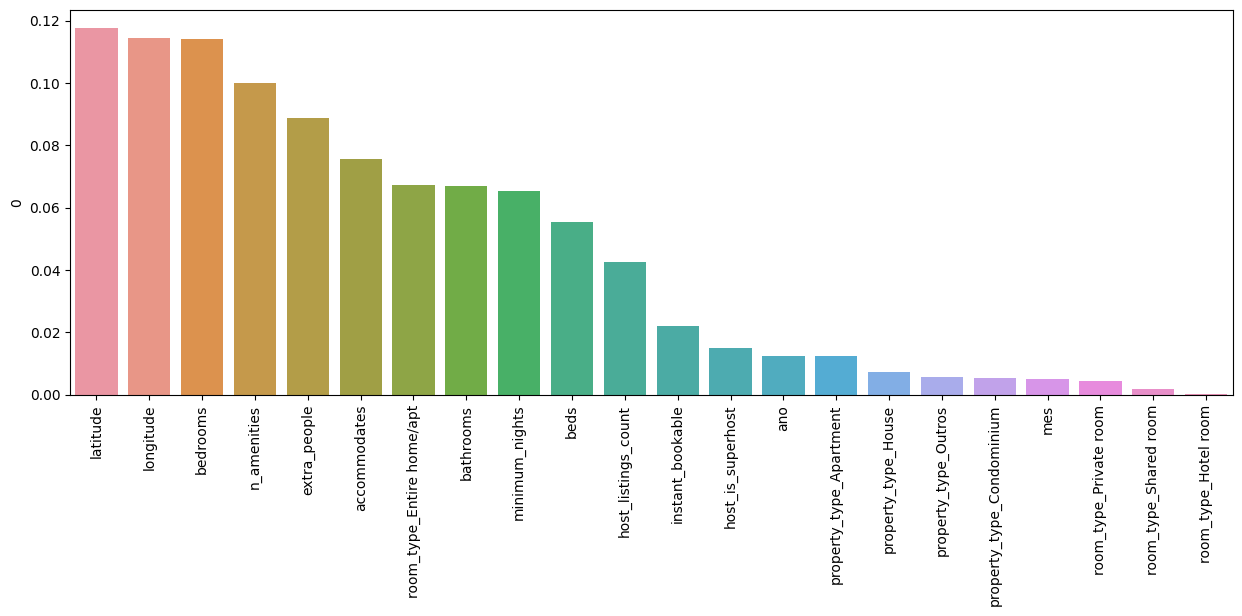

In [143]:
#print(modelo_et.feature_importances_)
#print( X_train.columns )

importancia_features = pd.DataFrame( modelo_et.feature_importances_, X_train.columns )
importancia_features = importancia_features.sort_values(by=0, ascending=False)
display(importancia_features)
plt.figure(figsize=(15, 5))
ax = sns.barplot(x=importancia_features.index, y=importancia_features[0])
ax.tick_params(axis='x', rotation=90)



# Model Fine Tunning 
- Ultimos ajustes e testes para o modelo, como exclusão de features e análise de seus respectivos impactos, as features identificadas como irrelevantes foram adicionadas suas exclusão na parte de tratamento de dados.

In [144]:
param_tuned = {
            'n_estimators':5000, 
            'eta': 0.01, 
            'max_depth': 25,
            'subsample': 0.6,
            'colsample_bytee': 0.3,
            'min_child_weight': 10
             }

In [145]:
# Model
model_xgb_tuned = xgb.XGBRegressor( objective='reg:squarederror', 
                                    n_estimators=param_tuned['n_estimators'], 
                                    eta=param_tuned['eta'], 
                                    max_depth=param_tuned['max_depth'],
                                    subsample=param_tuned['subsample'], 
                                    colsample_bytee=param_tuned['colsample_bytee'], 
                                    min_child_weight=param_tuned['min_child_weight'] ).fit( X_train, y_train )

# Prediction
yhat_xgb_tuned = model_xgb_tuned.predict( X_test )

# Performance 
xgb_result_tuned = ml_error( 'XGBoost Regressor',  y_test,  yhat_xgb_tuned ) 


In [146]:
xgb_result_tuned

Model Name        MAE          MAPE       RMSE        R2
0  XGBoost Regressor  15.109275  4.355003e+09  41.274303  0.975883

In [147]:
cv_xgb_result = cross_validation( X_train, 5, 'XGBoost', model_xgb, verbose=True )

cv_xgb_result


 KFold Number: 5

 KFold Number: 4

 KFold Number: 3

 KFold Number: 2

 KFold Number: 1


Model Name        MAE CV              MAPE CV       RMSE CV
0    XGBoost  2.73 +/- 0.0  197259500.0 +/- 0.0  6.77 +/- 0.0

In [78]:
import random 
import warnings
warnings.filterwarnings( 'ignore' )

In [148]:

X = base_airbnb_encoded.drop( 'price', axis=1 )
y = base_airbnb_encoded['price']

X_train, X_test, y_train, y_test = train_test_split( X, y, random_state=0 )


# Training
modelo_et.fit( X_train, y_train )
# Test
previsao = modelo_xgb.predict( X_test )
print( avaliar_modelo('ExtraTrees', y_test, previsao ) )


Modelo ExtraTrees: 
 R²:97.59%
 MAE:1510.93% 
 MAPE:435500320000.00% 
 RSME:41.27


In [149]:
base_teste = base_airbnb_encoded.copy()
for coluna in base_teste:
    if 'bed_type' in coluna:
        base_teste = base_teste.drop( coluna, axis=1 )
print( base_teste.columns )


X = base_teste.drop( 'price', axis=1 )
y = base_teste['price']

X_train, X_test, y_train, y_test = train_test_split( X, y, random_state=0 )


# Training
modelo_xgb.fit( X_train, y_train )
# Test
previsao = modelo_xgb.predict( X_test )
print( avaliar_modelo('XGBoost', y_test, previsao ) )

Index(['host_is_superhost', 'host_listings_count', 'latitude', 'longitude',
       'accommodates', 'bathrooms', 'bedrooms', 'beds', 'price',
       'extra_people', 'minimum_nights', 'instant_bookable', 'ano', 'mes',
       'n_amenities', 'property_type_Apartment', 'property_type_Condominium',
       'property_type_House', 'property_type_Outros',
       'room_type_Entire home/apt', 'room_type_Hotel room',
       'room_type_Private room', 'room_type_Shared room'],
      dtype='object')
Modelo XGBoost: 
 R²:97.59%
 MAE:1510.93% 
 MAPE:435500320000.00% 
 RSME:41.27


In [150]:
X['price'] = y
X.to_csv('dados.csv')

In [151]:
import pickle  
pickle.dump(model_xgb_tuned, open('model_rio.pkl', 'wb'))